In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import warnings
import shap
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_squared_log_error,r2_score,mean_absolute_error
import optuna
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
def read_dataset(file):
    if file.split('.')[1]=='csv':
        df = pd.read_csv(file)
    if file.split('.')[1]=='xlsx':
        df = pd.read_excel(file)
    return df

In [3]:
def missing_control_plot(df,image_path = None):
    df_null = df.isna().sum()
    missing_df = pd.DataFrame(
                  data=[df_null],
                  columns=df.columns,
                  index=["Null Size"]).T.sort_values("Null Size", ascending=False)
    missing_df = missing_df.loc[(missing_df["Null Size"] > 0)]
    #missing_df=missing_df.reset_index().rename(columns={'index':'Columns'})
    fig = px.bar(missing_df,x=missing_df.index, y="Null Size", hover_name='Null Size', 
                 color='Null Size',labels={
                         "index": "Columns",
                         },
                 color_discrete_sequence=['#D81F26'],template='plotly_dark',
                 title="Dataset Null Graph", width=1400, height=700)
    fig.update_layout(barmode='group')
    try:
        image = imread(image_path)
        fig, ax = plt.subplots(figsize=(15, 25))  
        ax.imshow(image)
        ax.axis('off')  
        plt.show()
    except:
        fig.show()
    return missing_df

In [4]:
def missing_count_plot(df,missing_df,variable_type,image_path=None):
    df_missing = df[missing_df.index]
    if variable_type=='num':
        liste = df_missing.loc[:, df_missing.dtypes != "object"].columns
        template = 'plotly_dark'
    if variable_type=='cat':
        liste = df_missing.loc[:, df_missing.dtypes == "object"].columns
        template = 'ggplot2'
    for index,i in enumerate(liste):
        x = df[i].unique()
        y = [df[i][df[i] == j].count() for j in x]
        bar = px.bar(df, x=x, y=y, text=y,labels={
                         "x": i,
                        "y":"count",
                         },
                          color_discrete_sequence=['#D81F26'],color=y,
                          template=template, title="Null Variable Count",
                          width=1000, height=500)
        try:
            image = imread(f"{image_path}_{variable_type}_{index}.png")
            fig, ax = plt.subplots(figsize=(15, 25))  
            ax.imshow(image)
            ax.axis('off')  
            plt.show()
        except:
            bar.show()

In [5]:
def corr_plot(df,target,image_path=None):
    corr = df.select_dtypes(exclude = ['object']).iloc[:,1:].corr()
    corr_list = corr[target].sort_values(axis=0,ascending=False).iloc[1:]
    corr_df = pd.DataFrame(corr_list)
    fig = px.bar(corr_df,x=corr_df.index, y=target, hover_name=target, 
                 color=target,labels={
                             "index": "Columns",
                            target:target,
                             },
                 color_discrete_sequence=['#D81F26'],template='plotly_dark',
                 title="Dataset Correlation Graph", width=1400, height=700)
    fig.update_layout(barmode='group')
    try:
        image = imread(image_path)
        fig, ax = plt.subplots(figsize=(15, 25))  
        ax.imshow(image)
        ax.axis('off')  
        plt.show()
    except:
        fig.show()

In [6]:
def missing_value_fill(data):
    df = data.copy()
    # BsmtFinType2: Quality of second finished area (if present)
    # BsmtFinType1: Quality of basement finished area
    # BsmtQual: Height of the basement
    # Fence: Fence quality
    # FireplaceQu: Fireplace quality
    # MasVnrArea: Masonry veneer area in square feet
    # MasVnrType: Masonry veneer type
    # MiscFeature: Miscellaneous feature not covered in other categories
    # PoolQC: Pool quality
    # LotFrontage: Linear feet of street connected to property
    # Alley: Type of alley access
    # BsmtCond: General condition of the basement
    # BsmtExposure: Walkout or garden level basement walls
    # Electrical: Electrical system
    # GarageType: Garage location
    # GarageFinish: Interior finish of the garage
    # GarageQual: Garage quality
    # GarageCond: Garage condition
    # GarageYrBlt: Year garage was built
    # NH : Not have
    # NB : No Basement
    # NF : No Fence
    # NFP : No Fireplace
    df['BsmtFinType2'] = df['BsmtFinType2'].fillna('NH')
    df['BsmtFinType1'] = df['BsmtFinType1'].fillna('NB')
    df['BsmtQual'] = df['BsmtQual'].fillna('NB')
    df['Fence'] = df['Fence'].fillna('NF')
    df['FireplaceQu'] = df['FireplaceQu'].fillna('NFP')
    # I filled in with 0 as most houses don't have it.
    df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].mode()[0])
    # I filled in the empty ones with None since the ones that didn't have the ownership information were labeled as None in the column data.
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MiscFeature'] = df['MiscFeature'].fillna('NH')
    df['PoolQC'] = df['PoolQC'].fillna('NH')
    # I grouped each house by its own neighborhood and filled in the missing values with the median.
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].apply(lambda x : x.fillna(x.median()))
    df['Alley'] = df['Alley'].fillna('NH')
    df['BsmtCond'] = df['BsmtCond'].fillna('NH')
    # I filled in the empty ones with No since the ones that didn't have the ownership information were labeled as No in the column data.
    df['BsmtExposure'] = df['BsmtExposure'].fillna('No')
    # I filled in with the most commonly used system for electrical systems in houses.
    df['Electrical']=df['Electrical'].fillna(train['BsmtExposure'].mode()[0])
    df['GarageType'] = df['GarageType'].fillna('NH')
    df['GarageFinish'] = df['GarageFinish'].fillna('NH')
    df['GarageQual'] = df['GarageQual'].fillna('NH')
    df['GarageCond'] = df['GarageCond'].fillna('NH')
    # To be able to fill in the missing values and group the years,
    #I first filled them with a year that is not in the selected column, then grouped the years,
    #and replaced the year that was not in the column with "NH".
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(2015).astype(int) 
    bins = [1900,1909,1919,1929,1939, 1949,1954, 1959,1964, 1969,1974, 1979,1984, 1989,1994,1999,2004,2010,2015]
    labels = ['1900-1909', '1910-1919','1920-1929','1930-1939','1940-1949','1950-1954','1955-1959','1960-1964',
              '1965-1969', '1970-1974', '1975-1979', '1980-1984','1985-1989','1990-1994','1995-1999','2000-2004','2005-2010','NH']
    df['GarageRangeBuilt'] = pd.cut(df['GarageYrBlt'], bins=bins, labels=labels).astype('object')
    return df

In [7]:
def feature_engineering(data):
    df = data.copy()
    # GarageArea: Size of garage in square feet
    # GarageCars: Size of garage in car capacity
    df["GarageCarSize"] = (df["GarageArea"] / df["GarageCars"]).fillna(0) 
    # GrLivArea: Above grade (ground) living area square feet
    # TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
    df["LivAreaRoomSize"] = df["GrLivArea"] / df["TotRmsAbvGrd"] 
    # TotalBsmtSF: Total square feet of basement area
    # 1stFlrSF: First Floor square feet
    # 2ndFlrSF: Second floor square feet
    df["TotalHouseSquareFeet"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]
    # BsmtFinSF1: Type 1 finished square feet
    # BsmtFinSF2: Type 2 finished square feet
    df["TotalBasementSquareFeet"] = df['BsmtFinSF1'] + df['BsmtFinSF2']
    # FullBath: Full bathrooms above grade
    # BsmtFullBath: Basement full bathrooms
    df["TotalFullBathSize"] = df["FullBath"] + df["BsmtFullBath"]
    # HalfBath: Half baths above grade
    # BsmtHalfBath: Basement half bathrooms
    df["TotalHalfBathSize"] = df["HalfBath"] + df["BsmtHalfBath"]
    # YrSold: Year Sold
    # YearBuilt: Original construction date
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    # YrSold: Year Sold
    # YearRemodAdd: Remodel date
    df["RemodHouseAge"] = df["HouseAge"] - (df["YrSold"] - df["YearRemodAdd"])
    # YearRemodAdd: Remodel date
    # YearBuilt: Original construction date
    df["IsRemod"] = (df["YearRemodAdd"] - df["YearBuilt"]).apply(lambda x: 1 if x > 0 else 0)
    # YrSold: Year Sold
    # GarageYrBlt: Year garage was built
    df["GarageAge"] = df["YrSold"] - df["GarageYrBlt"]
    # OverallQual: Overall material and finish quality
    # OverallCond: Overall condition rating
    # The quality of the old and new house may be the same, I have added the age of the house to find the difference.
    df["YearHouseQuality"] = (df["OverallQual"] + df["OverallCond"]) / 2 + (2010-df['YearBuilt'])
    # WoodDeckSF: Wood deck area in square feet
    # OpenPorchSF: Open porch area in square feet
    # EnclosedPorch: Enclosed porch area in square feet
    # 3SsnPorch: Three season porch area in square feet
    # ScreenPorch: Screen porch area in square feet
    df['HouseTotalPorchSquareFeet'] = (df['OpenPorchSF'] 
                                  + df['3SsnPorch'] 
                                  + df['EnclosedPorch'] 
                                  + df['ScreenPorch'] 
                                  + df['WoodDeckSF']
                                 )
    # PoolArea: Pool area in square feet
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    # 2ndFlrSF: Second floor square feet
    df['Has2ndFloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    # GarageArea: Size of garage in square feet
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    #TotalBsmtSF: Total square feet of basement area
    df['HasBasement'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    # Fireplaces: Number of fireplaces
    df['HasFirePlace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

    df = df.drop([
        "GarageArea", "GarageCars", "GrLivArea", 
        "TotRmsAbvGrd", "TotalBsmtSF", "1stFlrSF", 
        "2ndFlrSF", "FullBath", "BsmtFullBath", "HalfBath", 
        "BsmtHalfBath", "YrSold", "YearBuilt", "YearRemodAdd",
        "GarageYrBlt", "OpenPorchSF", "EnclosedPorch", "3SsnPorch",
        "ScreenPorch", "OverallQual", "OverallCond",'Utilities',
        'Street','PoolQC','BsmtFinSF1','BsmtFinSF2','HouseAge','WoodDeckSF','PoolArea','2ndFlrSF','Fireplaces'
    ], axis=1)
    return df

In [8]:
def pipeline_build(X_train,X_test,missing_num_cols,ordinal_cols,cat_cols):
    X_train = missing_value_fill(X_train)
    X_test = missing_value_fill(X_test)
    for missing_col in missing_num_cols:
        if missing_col in X_train.columns.tolist():
            train_median = X_train[missing_col].median()

            X_train.loc[:, missing_col] = X_train.loc[:, missing_col].fillna(train_median)
            X_test.loc[:, missing_col] = X_test.loc[:, missing_col].fillna(train_median)
    X_train = feature_engineering(X_train)
    X_test = feature_engineering(X_test)
    for col in ordinal_cols:
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        if col in X_train.columns.tolist():
            X_train.loc[:, col] = encoder.fit_transform(X_train.loc[:, col].values.reshape(-1, 1))
            X_test.loc[:, col] = encoder.transform(X_test.loc[:, col].values.reshape(-1, 1))
    for i in cat_cols.copy():
        if i not in X_train.columns.tolist():
            cat_cols.remove(i)
    ohe = OneHotEncoder(handle_unknown='ignore')

    ohe.fit(X_train[cat_cols])

    train_ohe = pd.DataFrame(ohe.transform(X_train[cat_cols]).toarray(), 
                             columns=ohe.get_feature_names_out(cat_cols))

    val_ohe = pd.DataFrame(ohe.transform(X_test[cat_cols]).toarray(),
                           columns=ohe.get_feature_names_out(cat_cols))

    X_train = pd.concat([X_train.reset_index(drop=True), 
                              train_ohe.reset_index(drop=True)], axis=1)
    X_test = pd.concat([X_test.reset_index(drop=True), 
                            val_ohe.reset_index(drop=True)], axis=1)

    X_train = X_train.drop(cat_cols, 
                                     axis=1)
    X_test = X_test.drop(cat_cols,
                                 axis=1)
    return X_train,X_test

In [9]:
train = read_dataset("C:/Users/MahmutYAVUZ/Desktop/Software/Python/kaggle/regression/data/raw/train.csv")
test = read_dataset('C:/Users/MahmutYAVUZ/Desktop/Software/Python/kaggle/regression/data/external/test.csv')

In [10]:
train

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

In [11]:
test

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461          20       RH         80.0    11622   Pave   NaN      Reg   
1     1462          20       RL         81.0    14267   Pave   NaN      IR1   
2     1463          60       RL         74.0    13830   Pave   NaN      IR1   
3     1464          60       RL         78.0     9978   Pave   NaN      IR1   
4     1465         120       RL         43.0     5005   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub  ...         120        0    NaN  MnPrv   
1            Lvl    AllPub  ...           0        0    NaN    NaN   
2            Lvl    AllPub  ...           0        0    NaN  MnPrv   
3            Lvl    AllPub  ...           0        0    NaN    NaN   
4            HLS    AllPub  ...         144        0    NaN    NaN   
...          ...       ...  ...         ...      ...    ...    ...   
1454         Lvl    AllPub  ...           0        0    NaN    NaN   
1455         Lvl    AllPub  ...           0        0    NaN    NaN   
1456         Lvl    AllPub  ...           0        0    NaN    NaN   
1457         Lvl    AllPub  ...           0        0    NaN  MnPrv   
1458         Lvl    AllPub  ...           0        0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0            NaN       0      6    2010        WD         Normal  
1           Gar2   12500      6    2010        WD         Normal  
2            NaN       0      3    2010        WD         Normal  
3            NaN       0      6    2010        WD         Normal  
4            NaN       0      1    2010        WD         Normal  
...          ...     ...    ...     ...       ...            ...  
1454         NaN       0      6    2006        WD         Normal  
1455         NaN       0      4    2006        WD        Abnorml  
1456         NaN       0      9    2006        WD        Abnorml  
1457        Shed     700      7    2006        WD         Normal  
1458         NaN       0     11    2006        WD         Normal  

[1459 rows x 80 columns]

In [12]:
target = 'SalePrice'

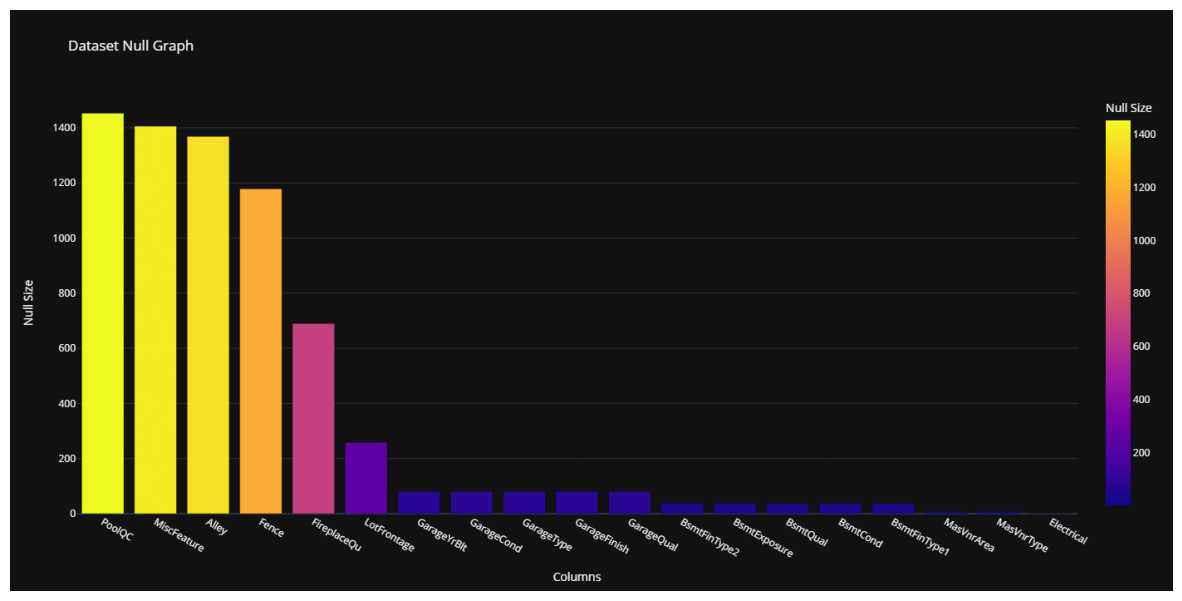

In [13]:
# GitHub only displays static images, so I saved the images and visualized them later.
missing_train = missing_control_plot(train,'C:/Users/MahmutYAVUZ/Desktop/Software/Python/kaggle/regression/images/missing_control_plot_train.png')

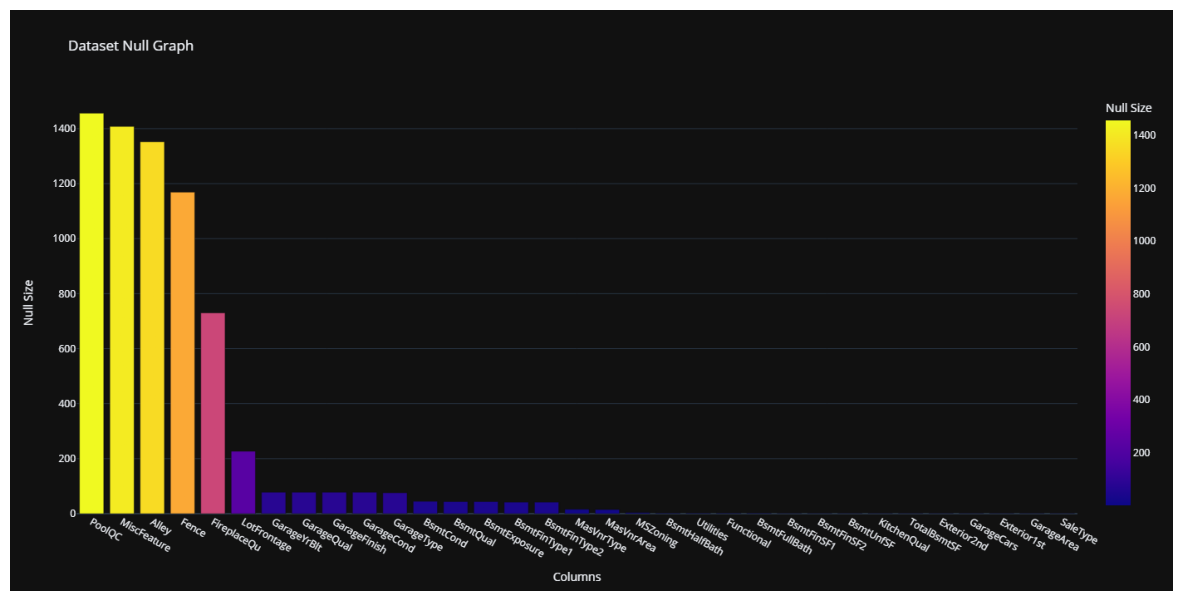

In [14]:
# GitHub only displays static images, so I saved the images and visualized them later.
missing_test = missing_control_plot(test,'C:/Users/MahmutYAVUZ/Desktop/Software/Python/kaggle/regression/images/missing_control_plot_test.png')

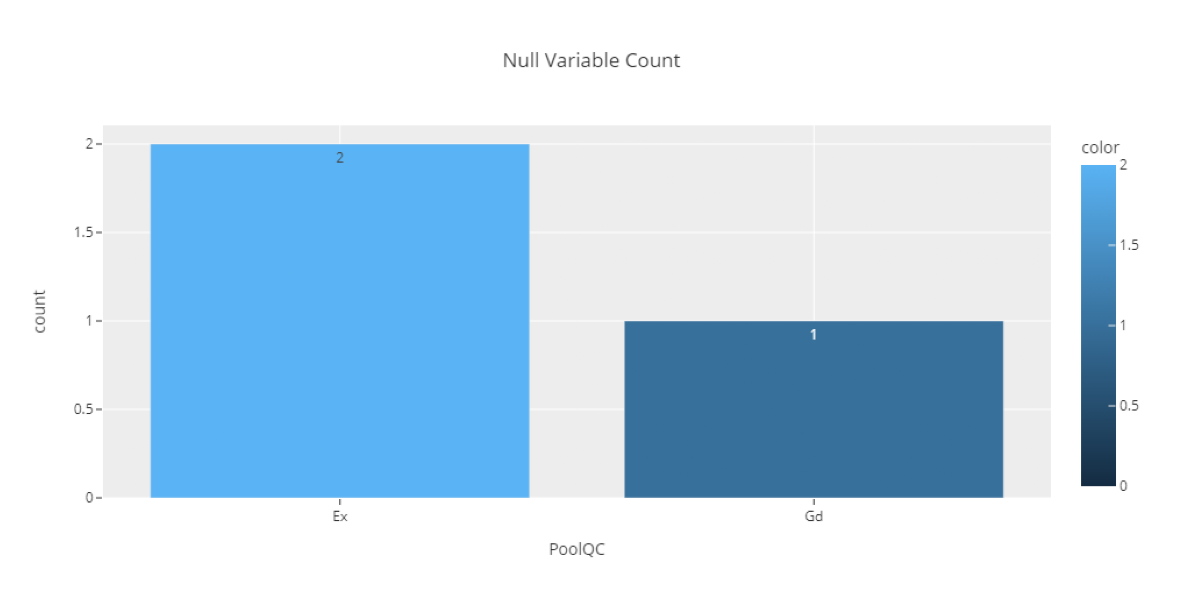

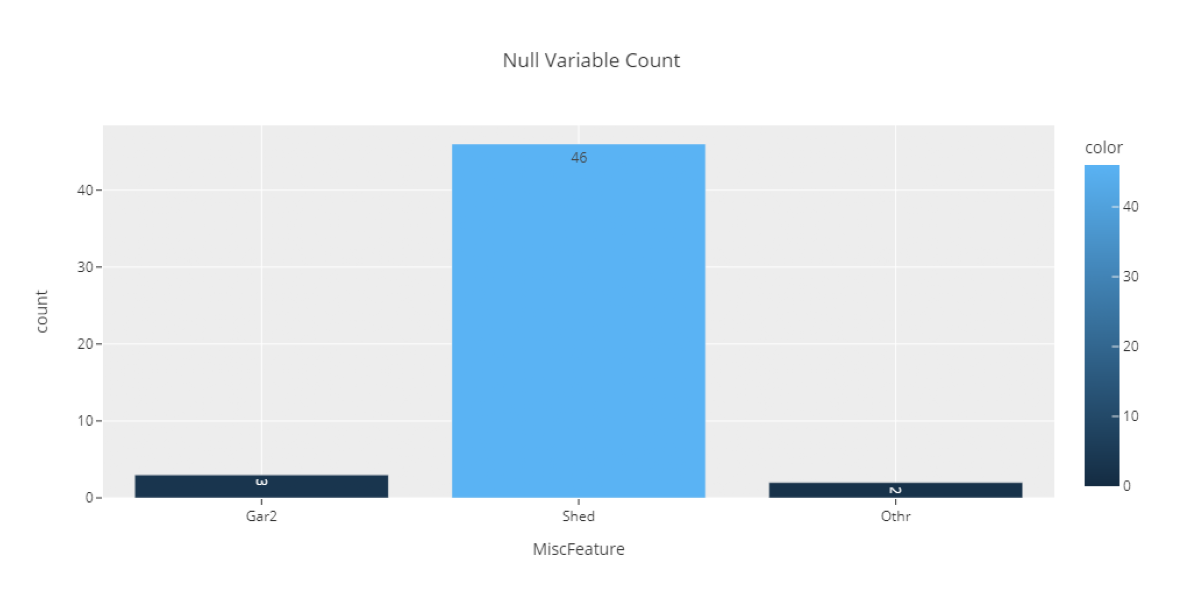

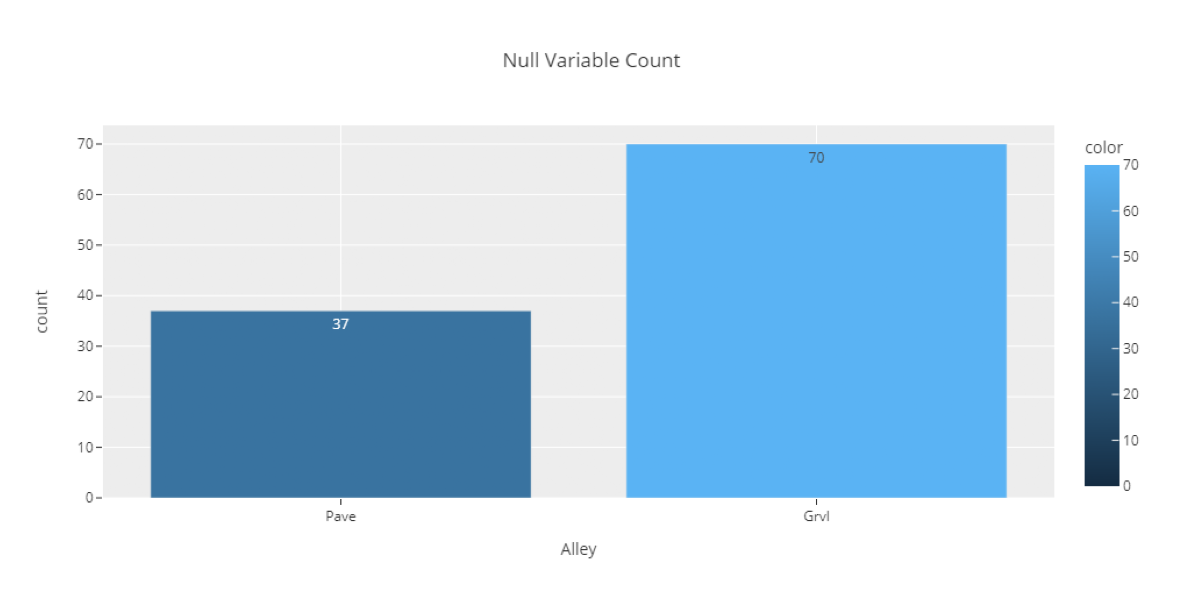

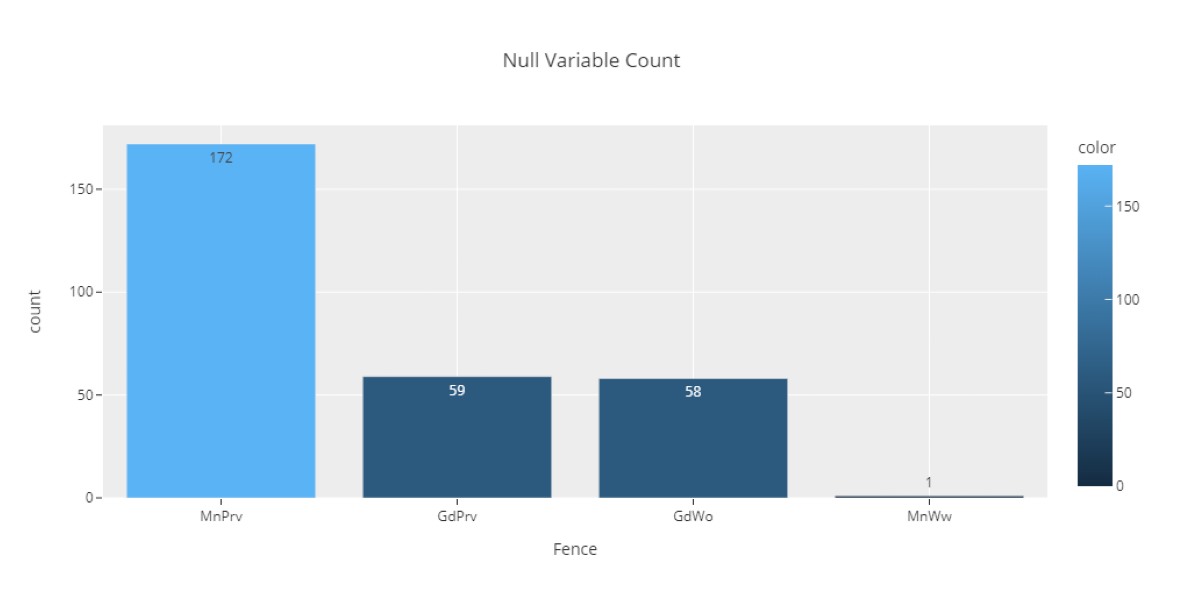

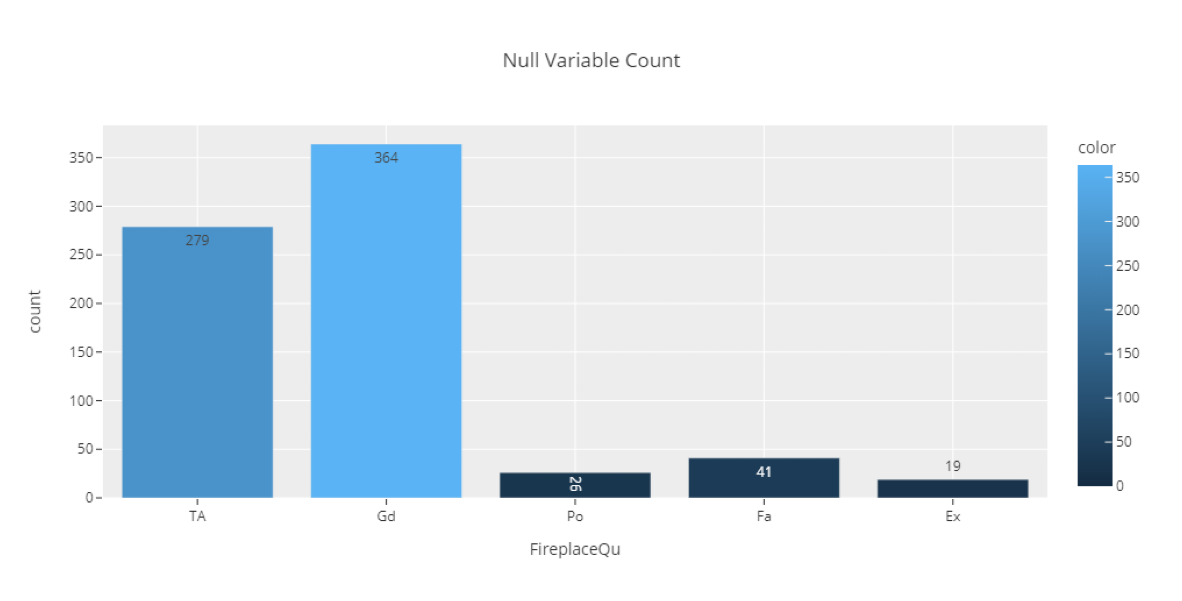

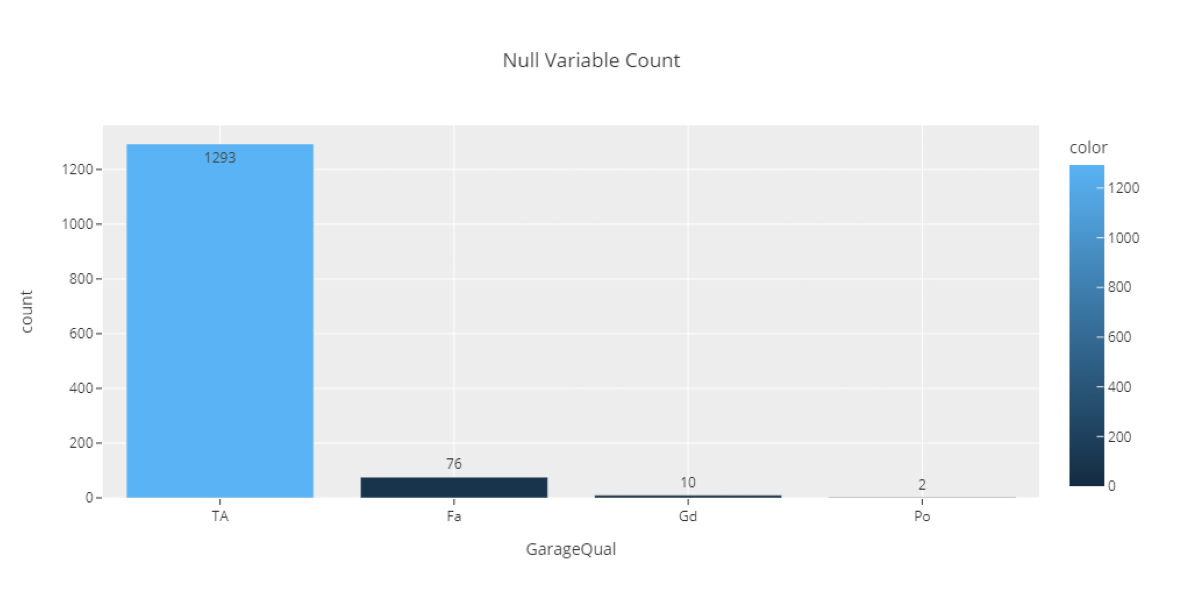

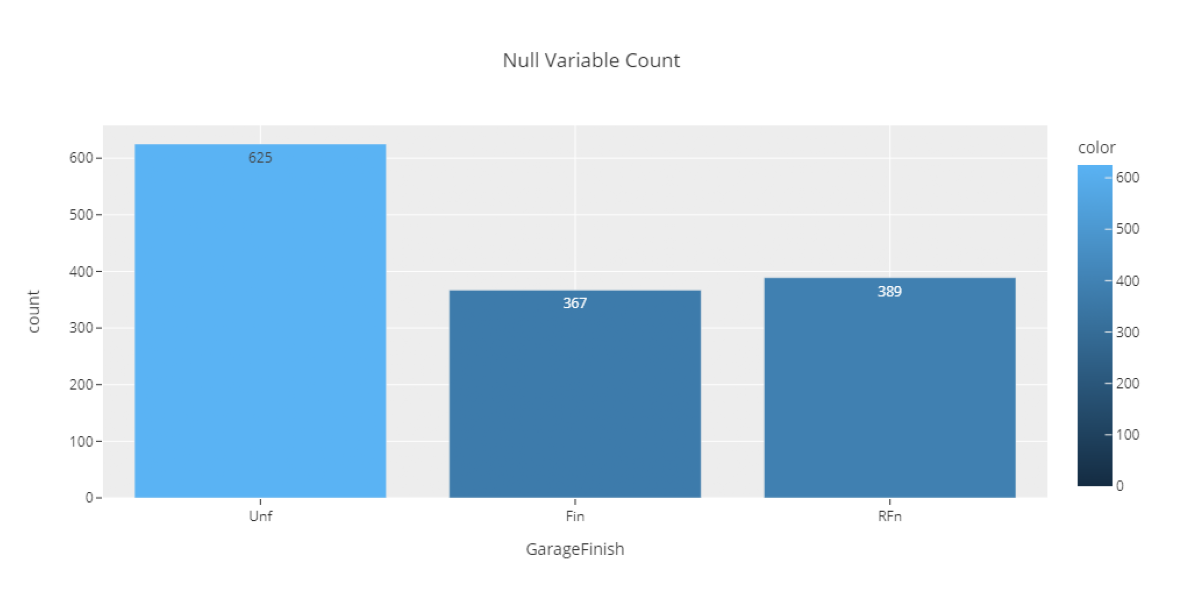

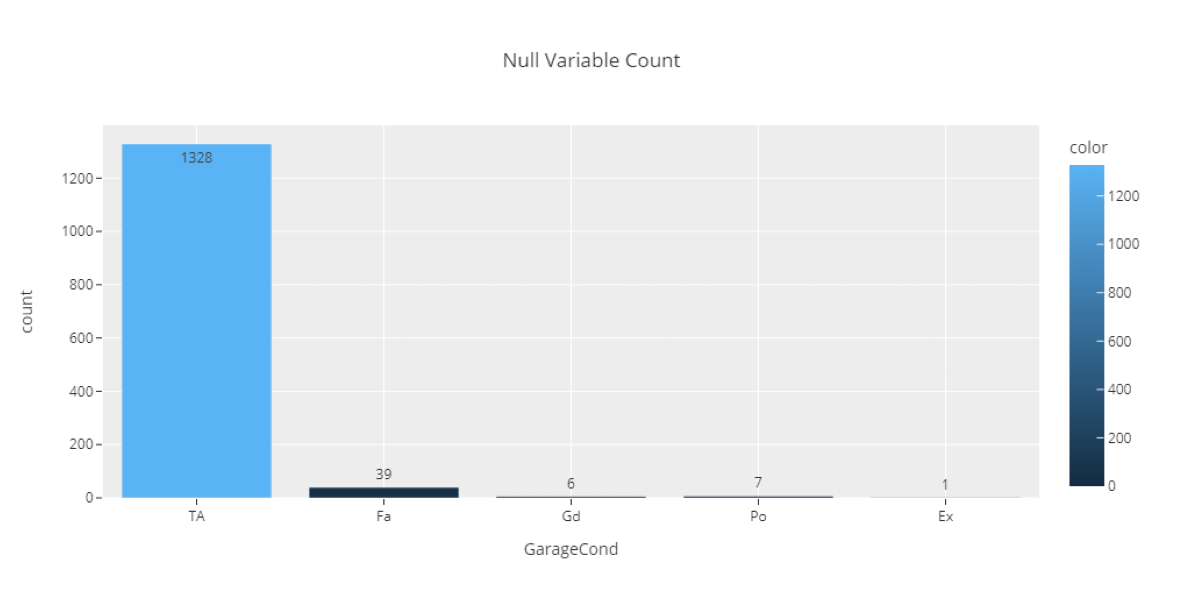

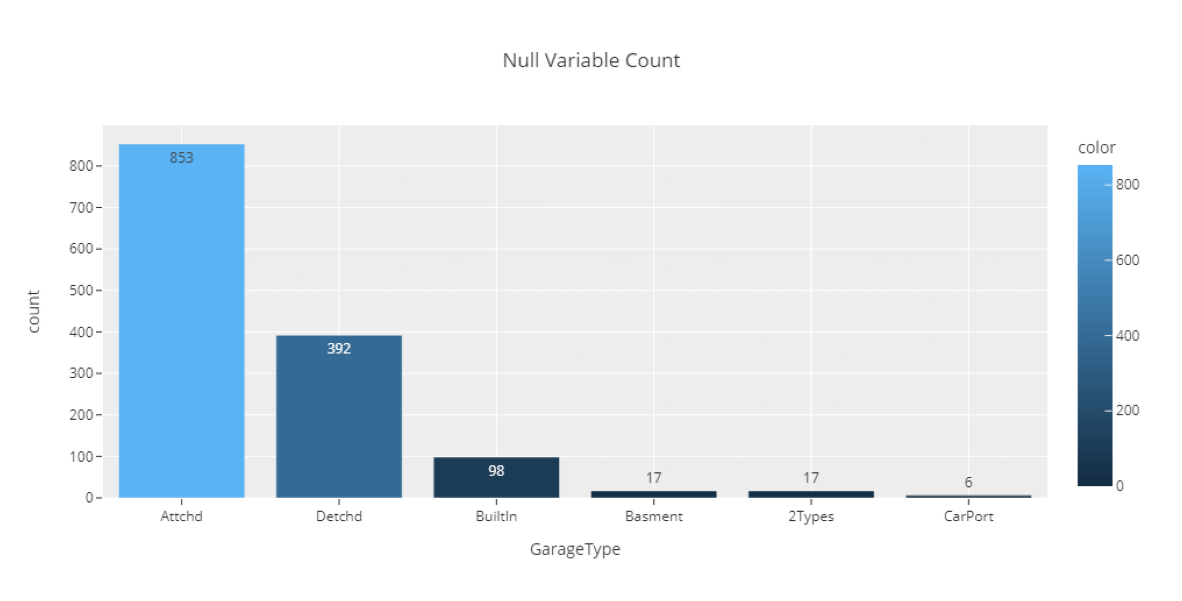

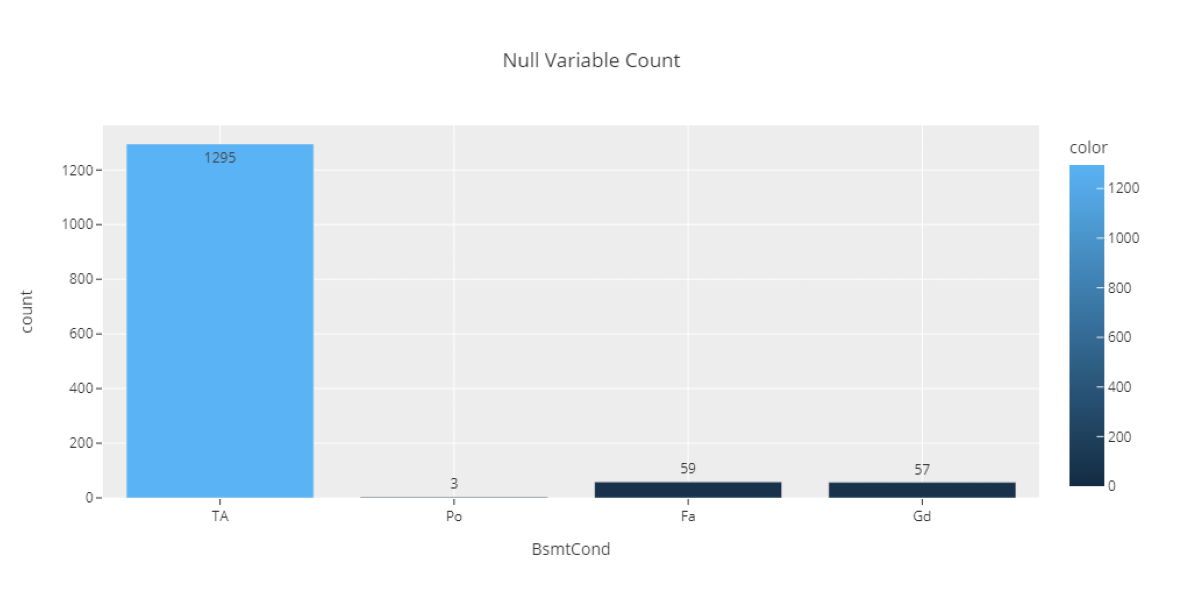

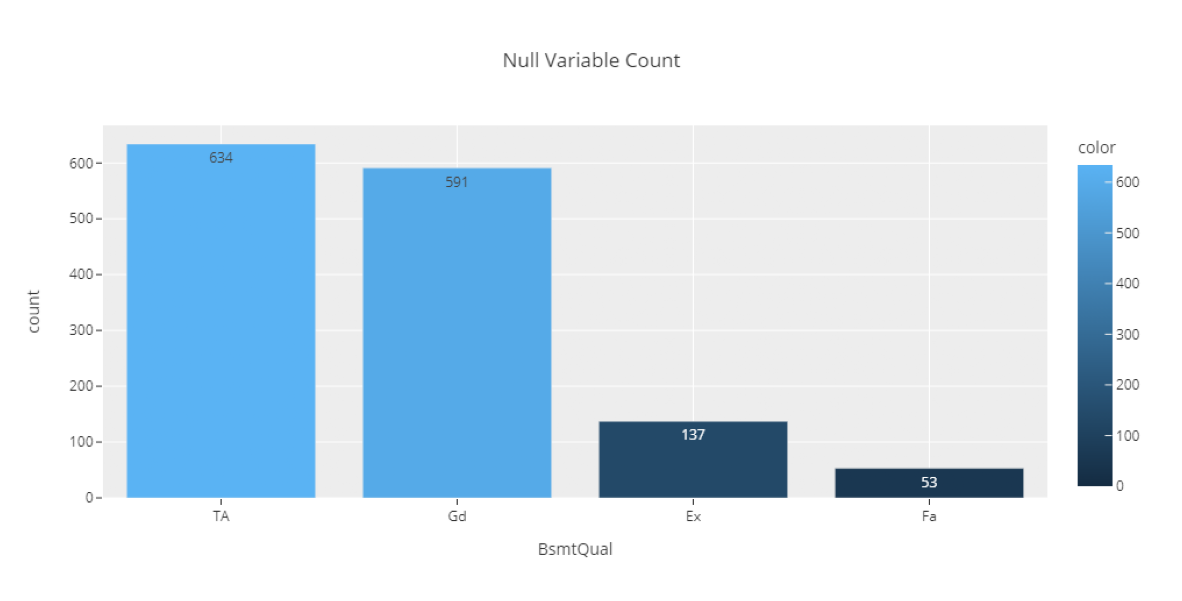

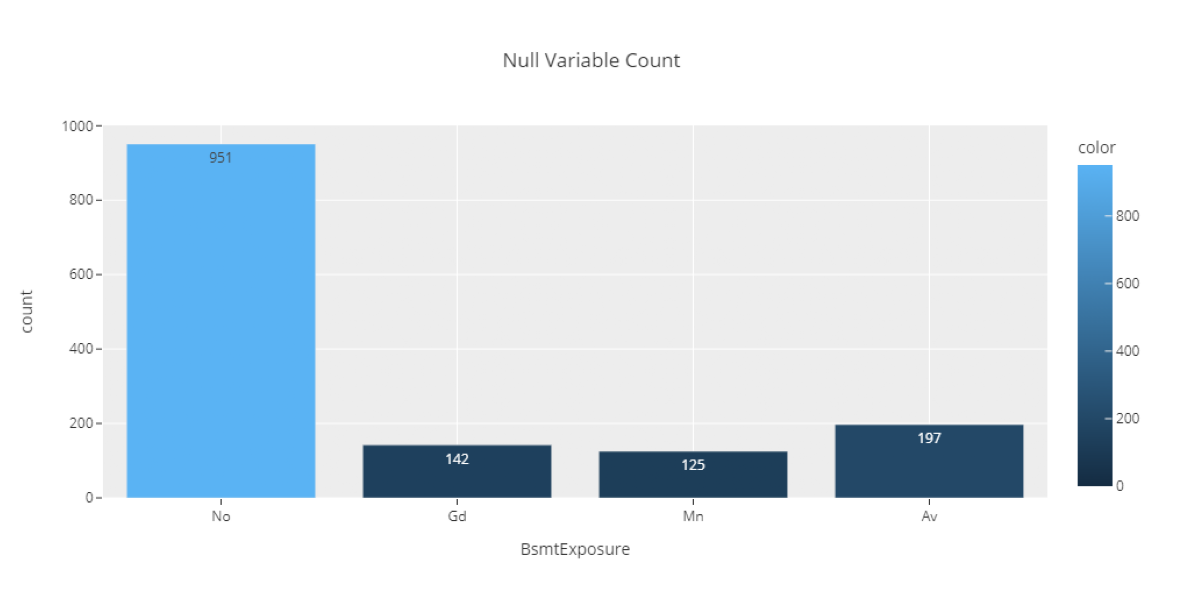

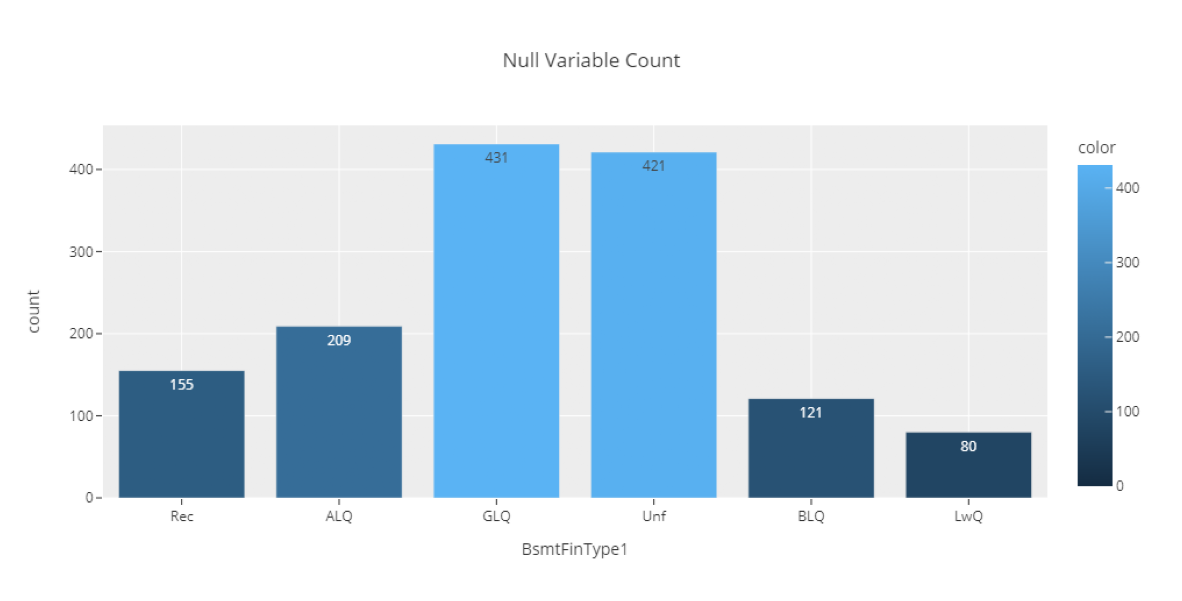

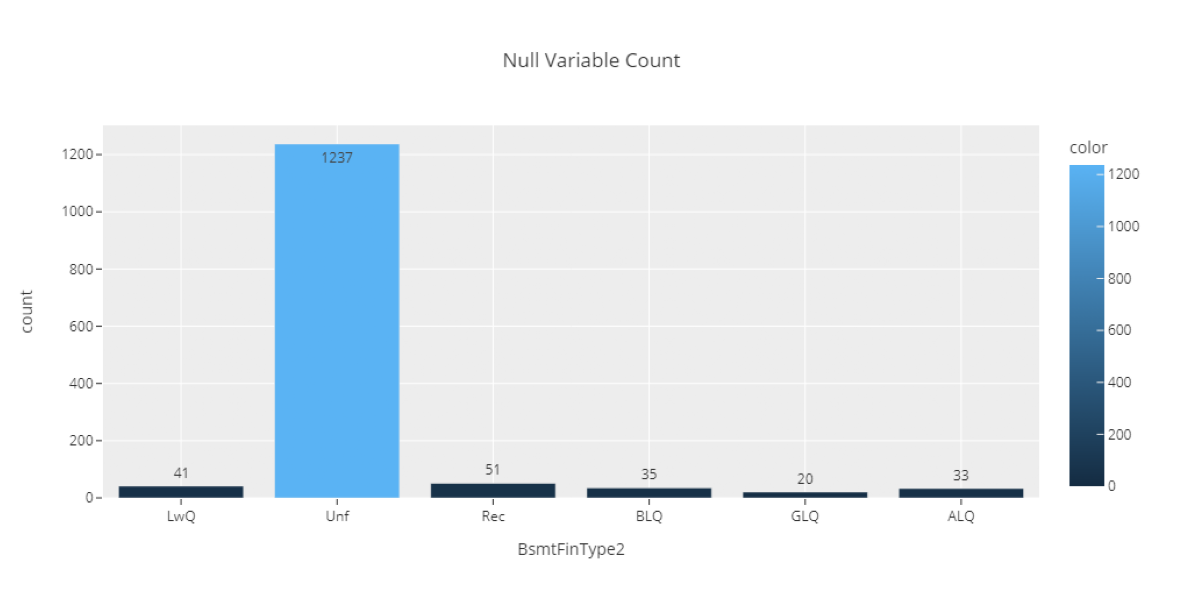

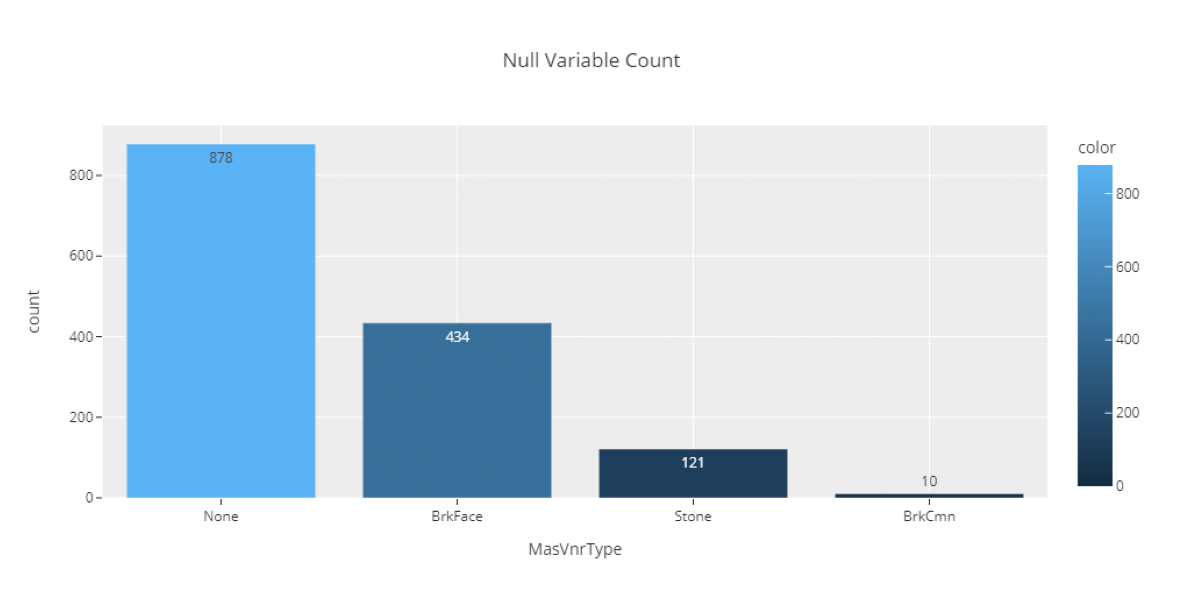

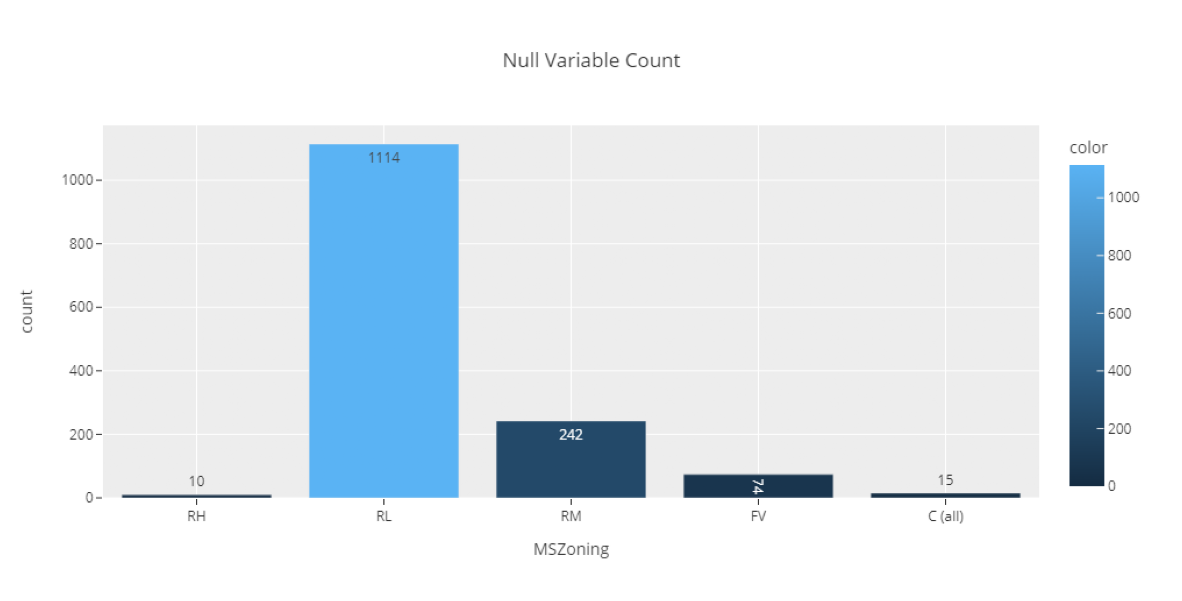

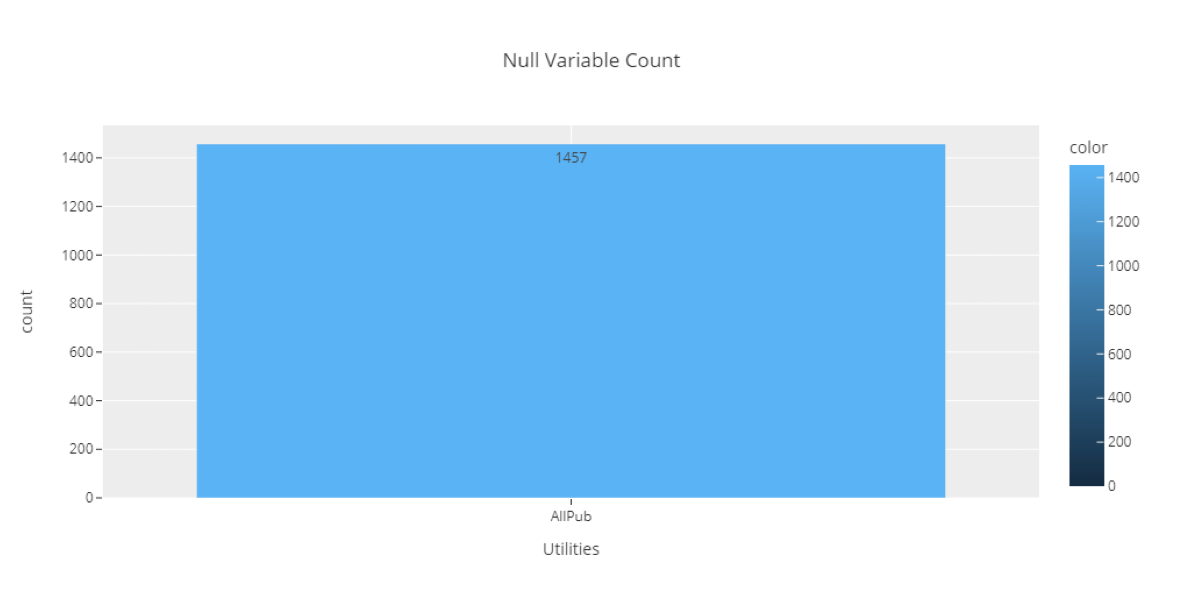

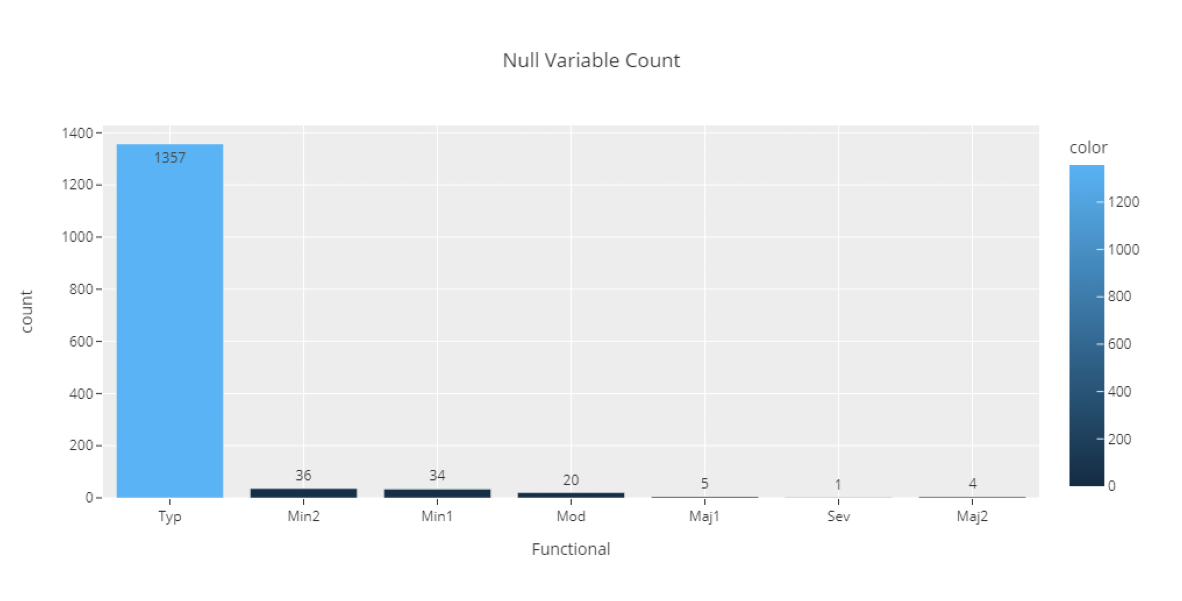

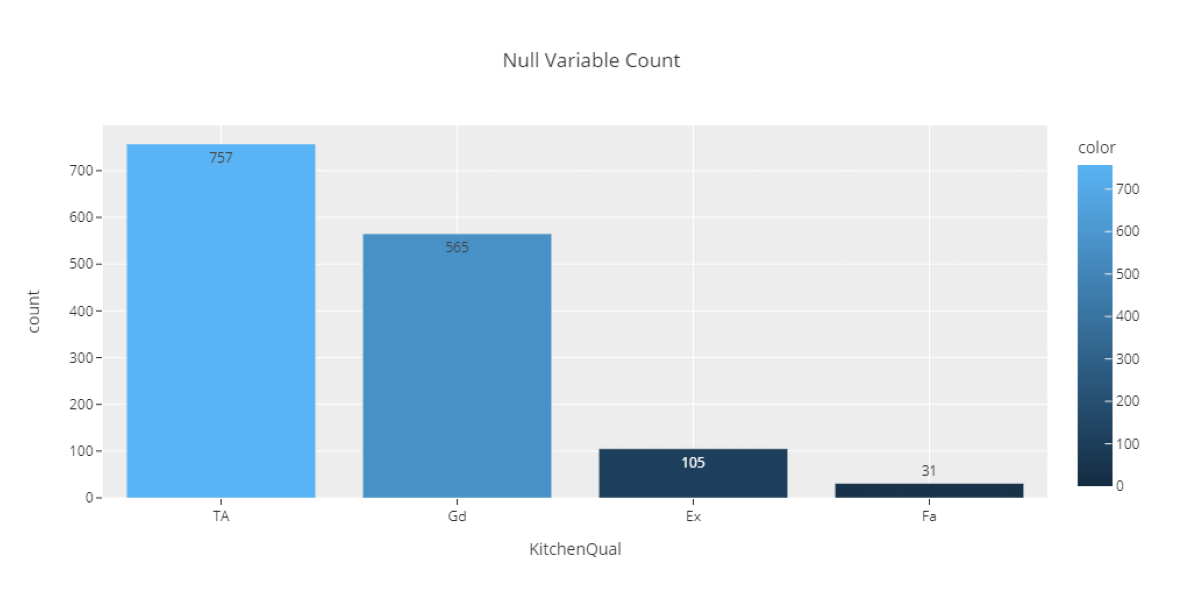

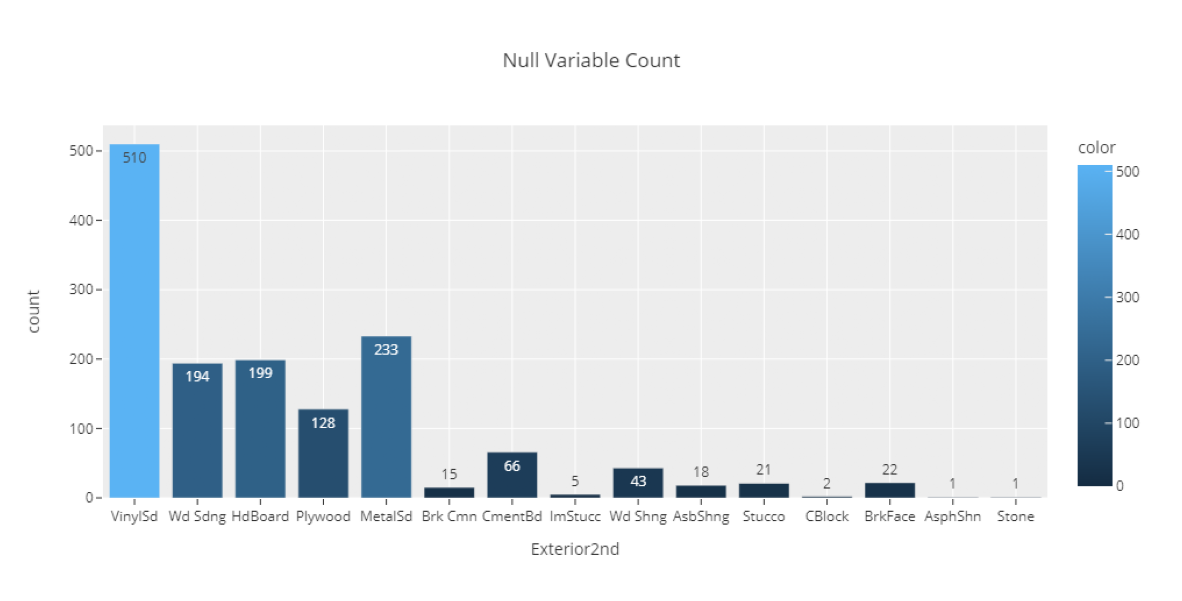

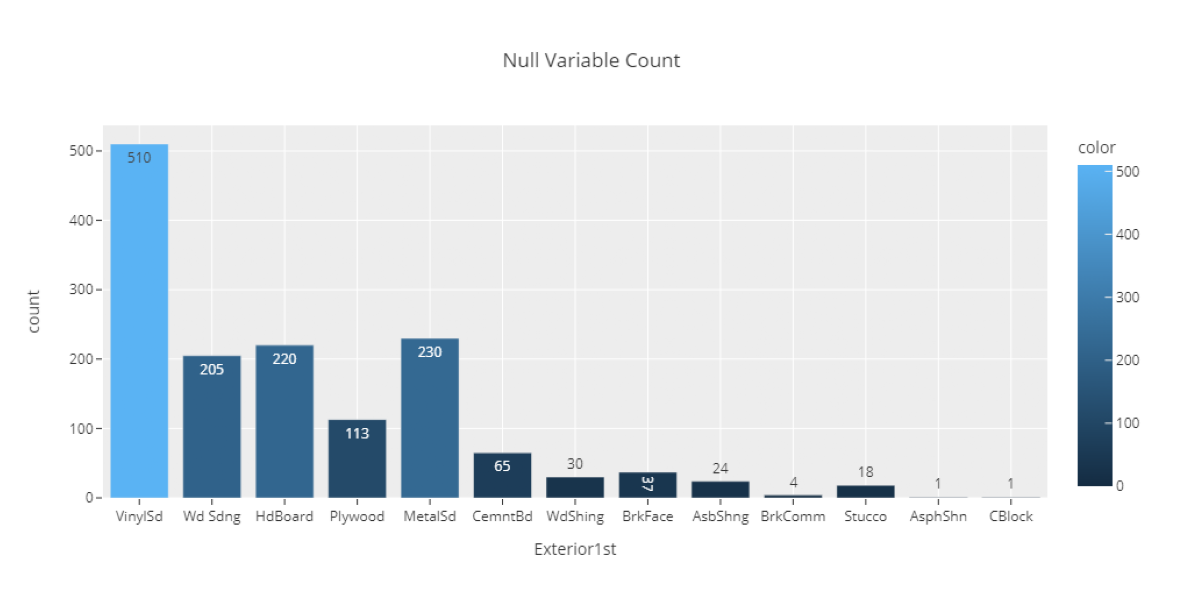

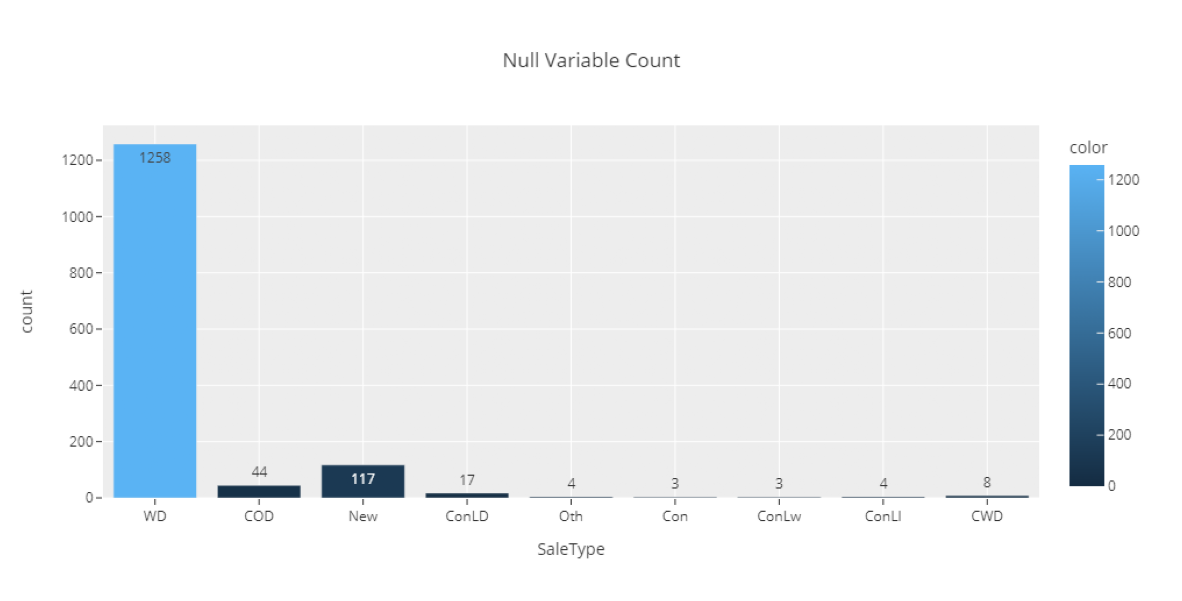

In [15]:
# GitHub only displays static images, so I saved the images and visualized them later.
missing_count_plot(test,missing_test,variable_type='cat',image_path='C:/Users/MahmutYAVUZ/Desktop/Software/Python/kaggle/regression/images/missing_count_plot')

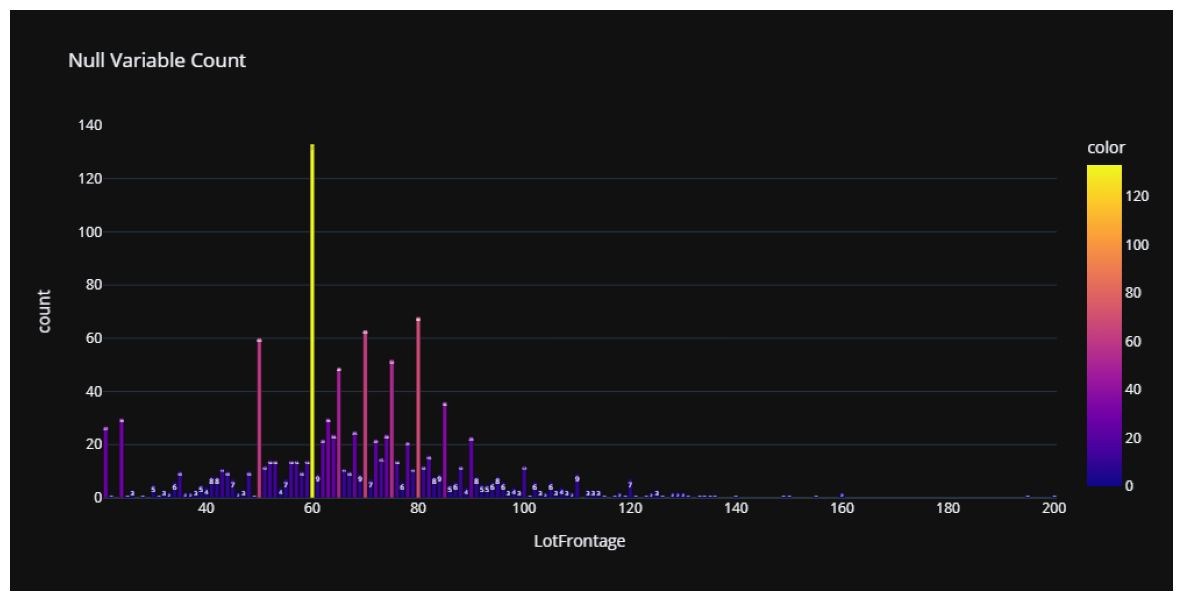

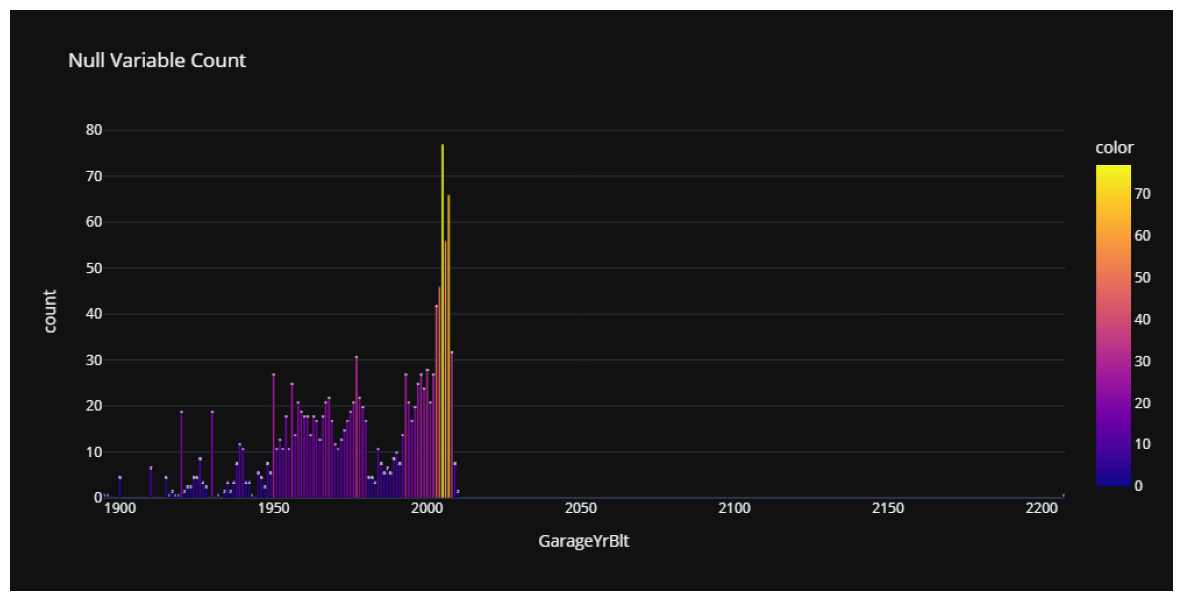

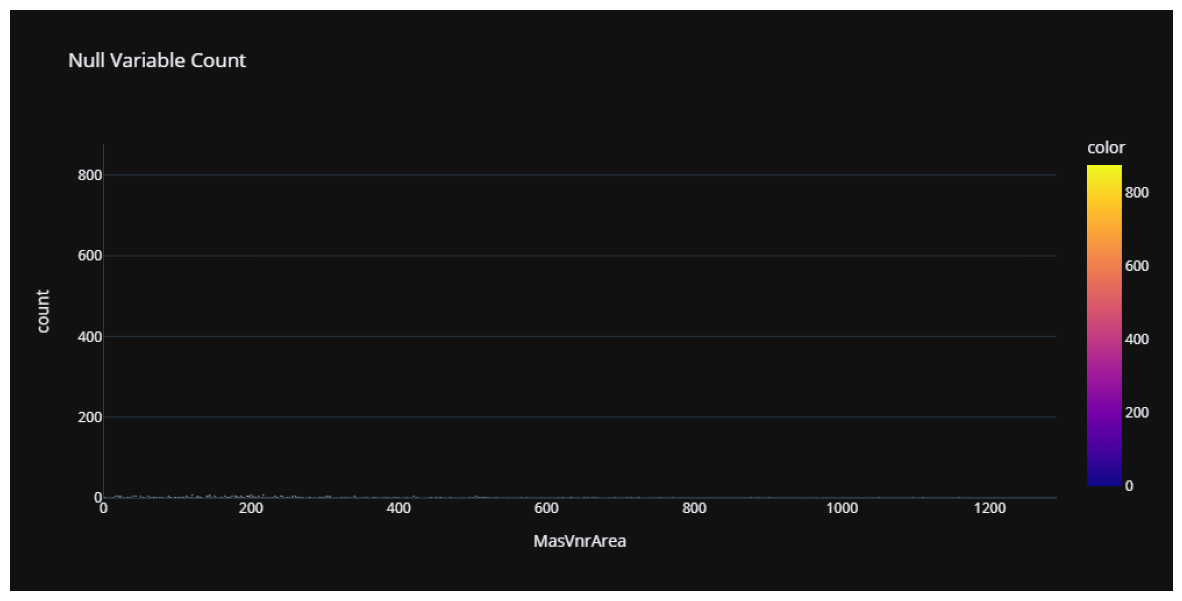

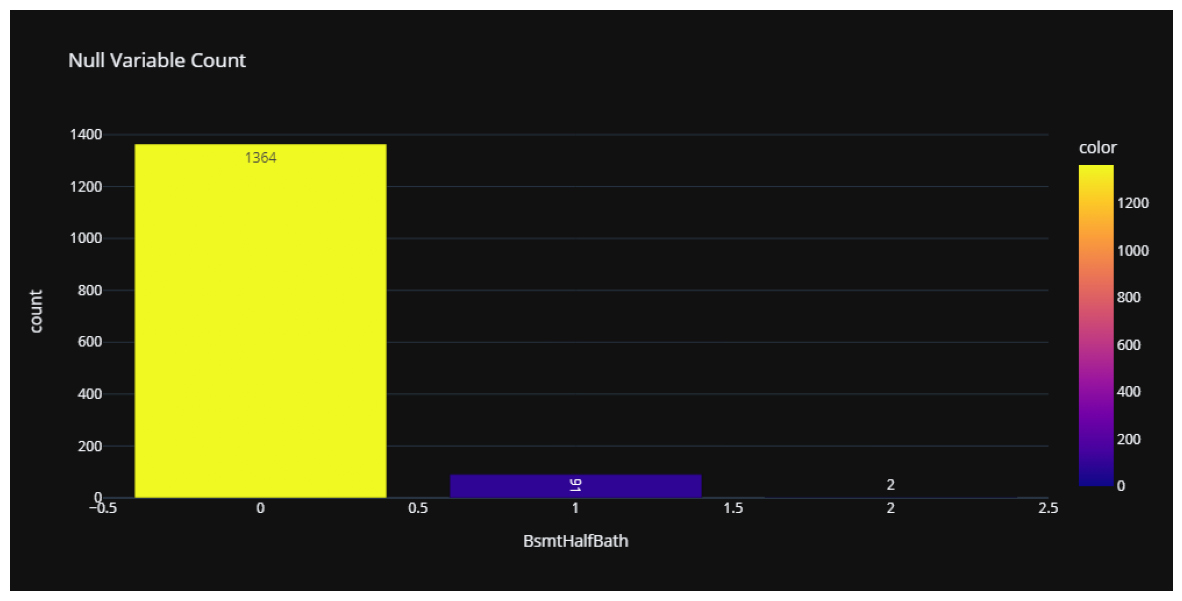

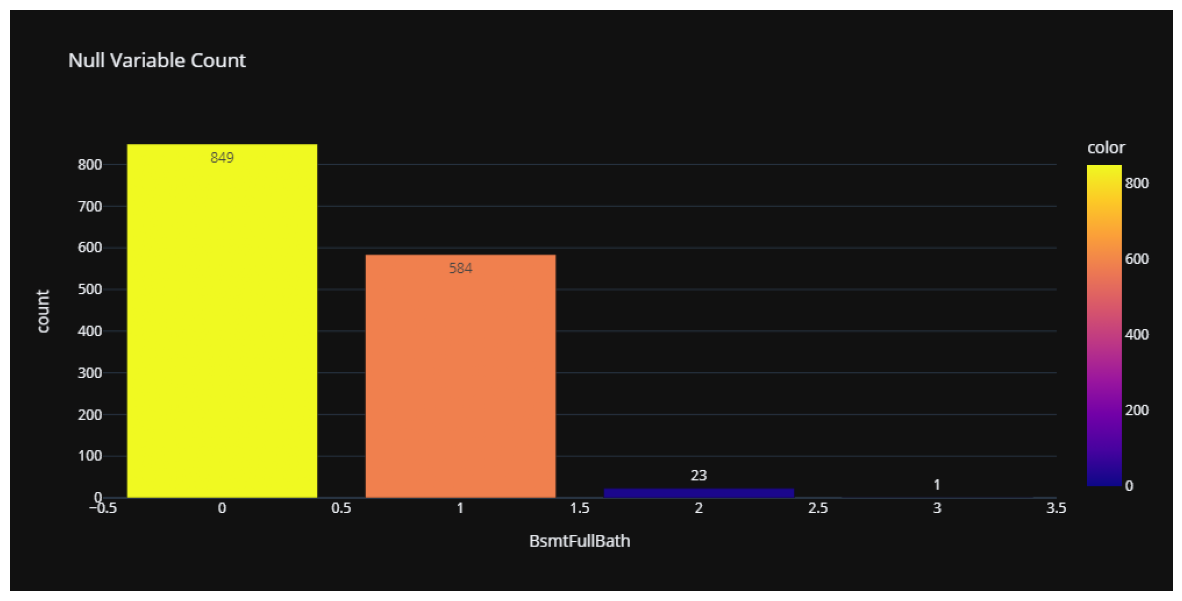

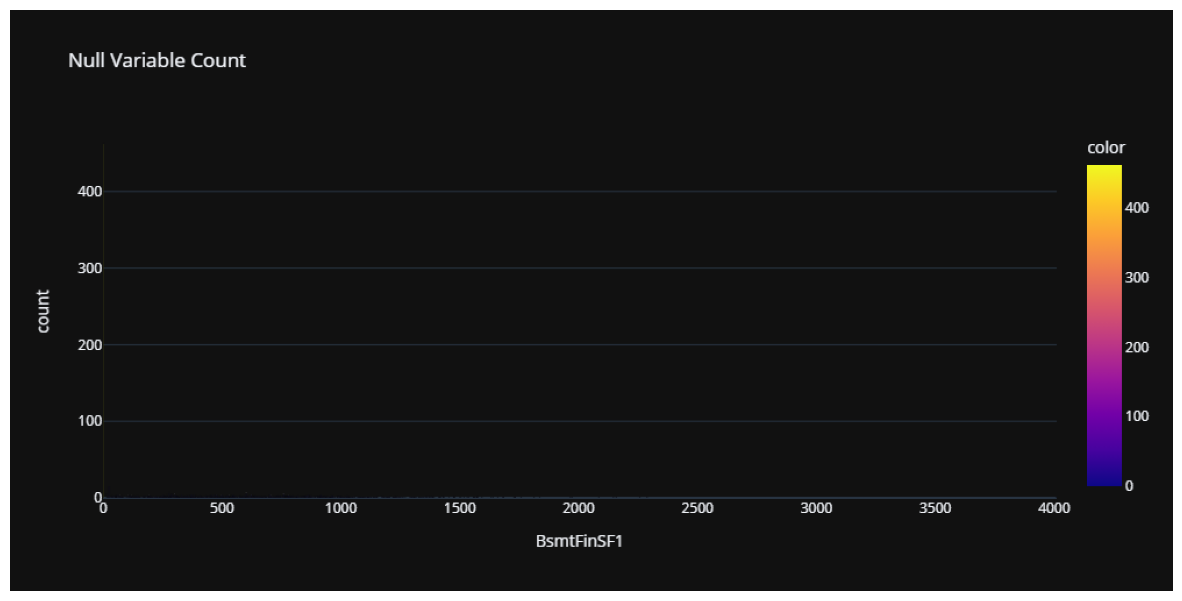

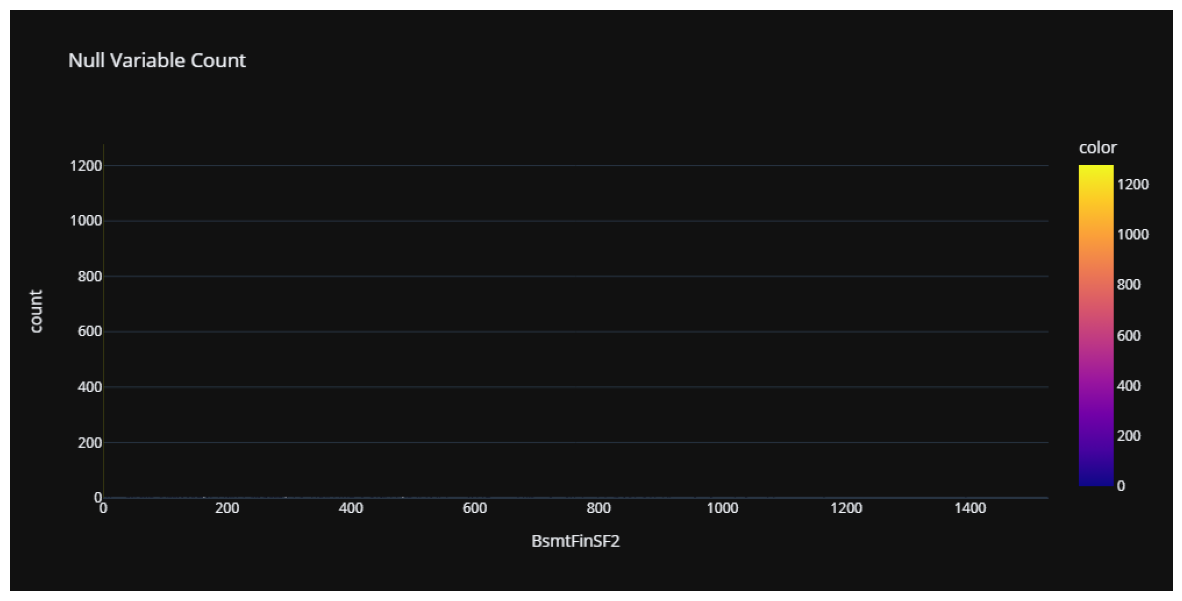

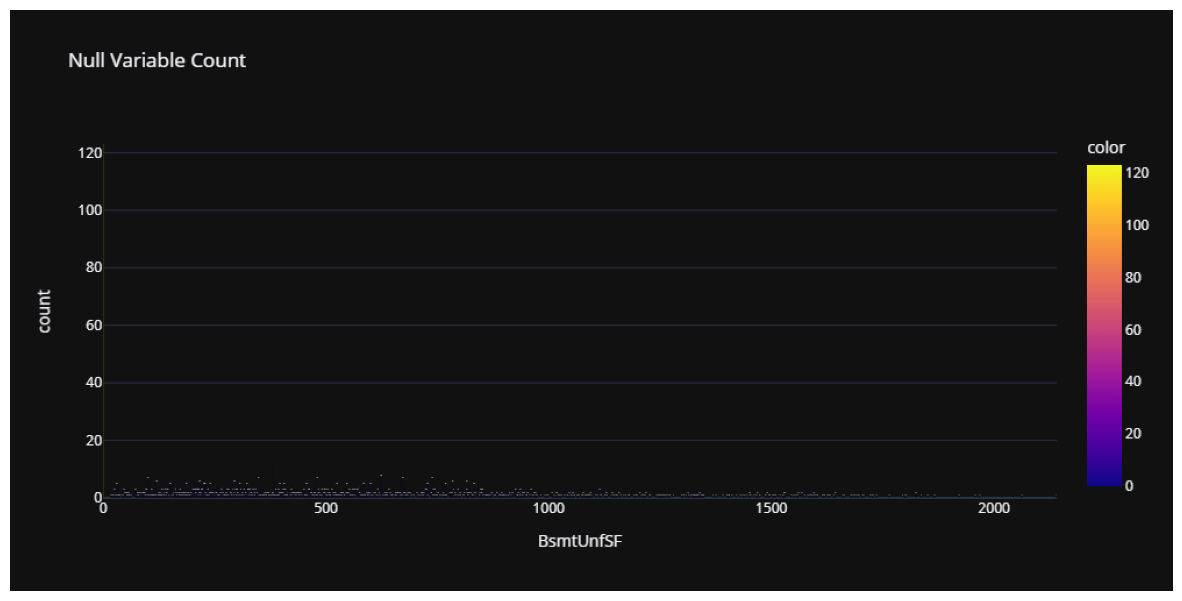

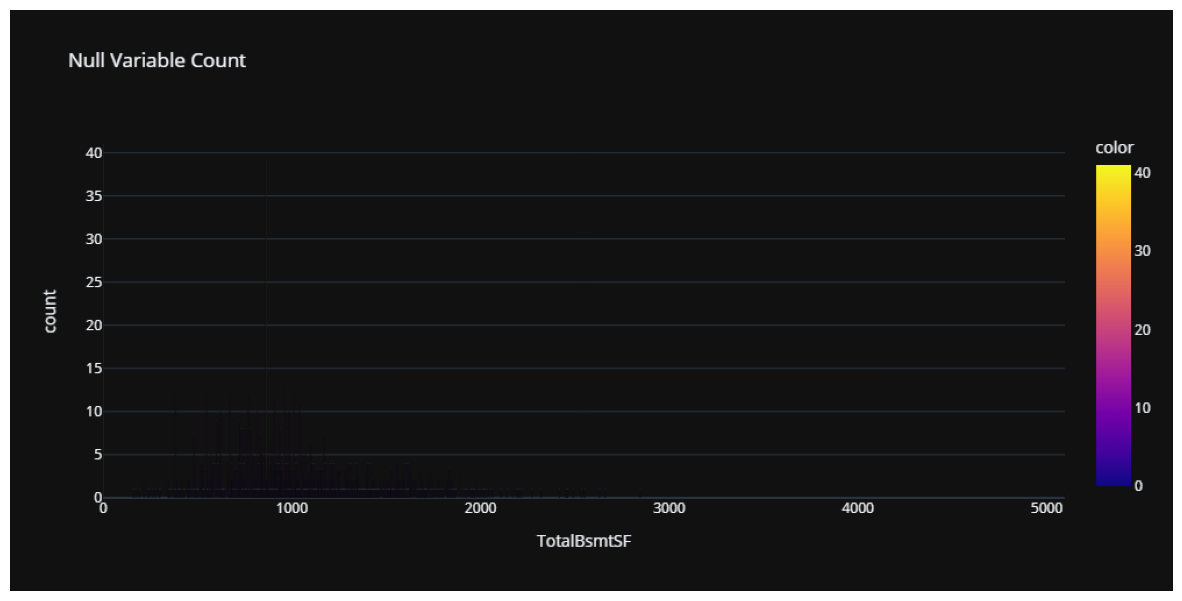

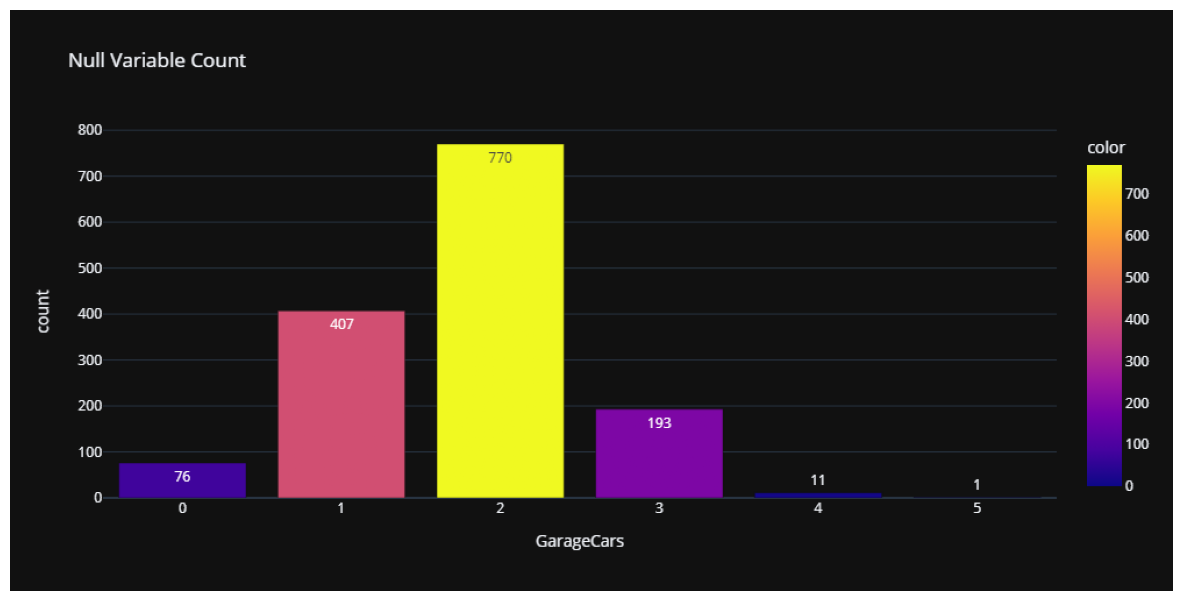

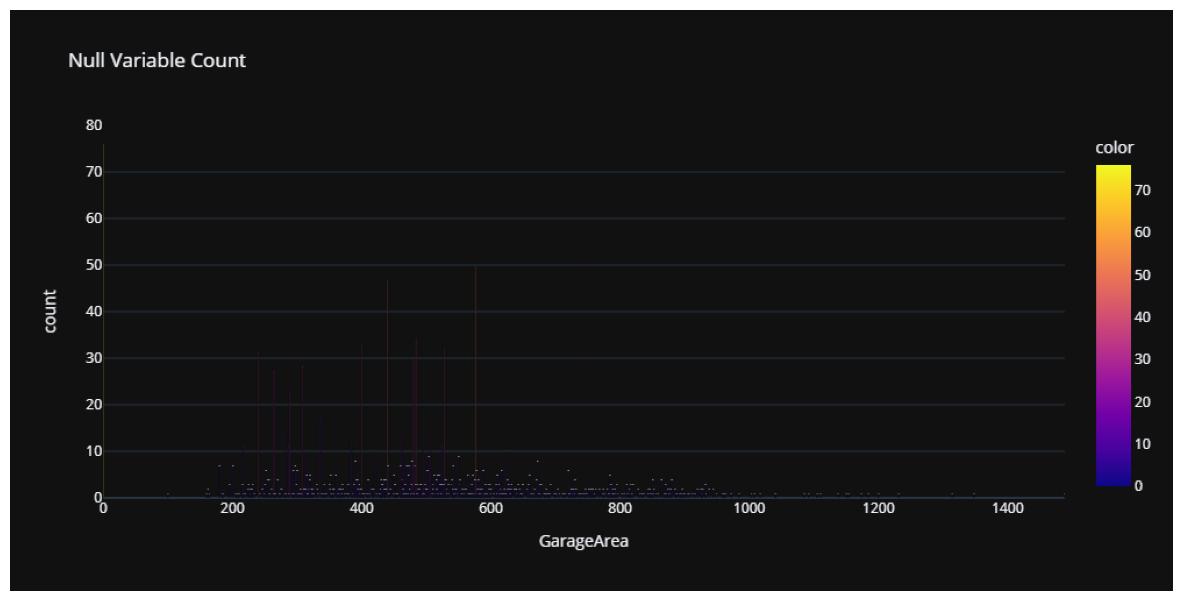

In [16]:
# GitHub only displays static images, so I saved the images and visualized them later.
missing_count_plot(test,missing_test,variable_type='num',image_path='C:/Users/MahmutYAVUZ/Desktop/Software/Python/kaggle/regression/images/missing_count_plot')

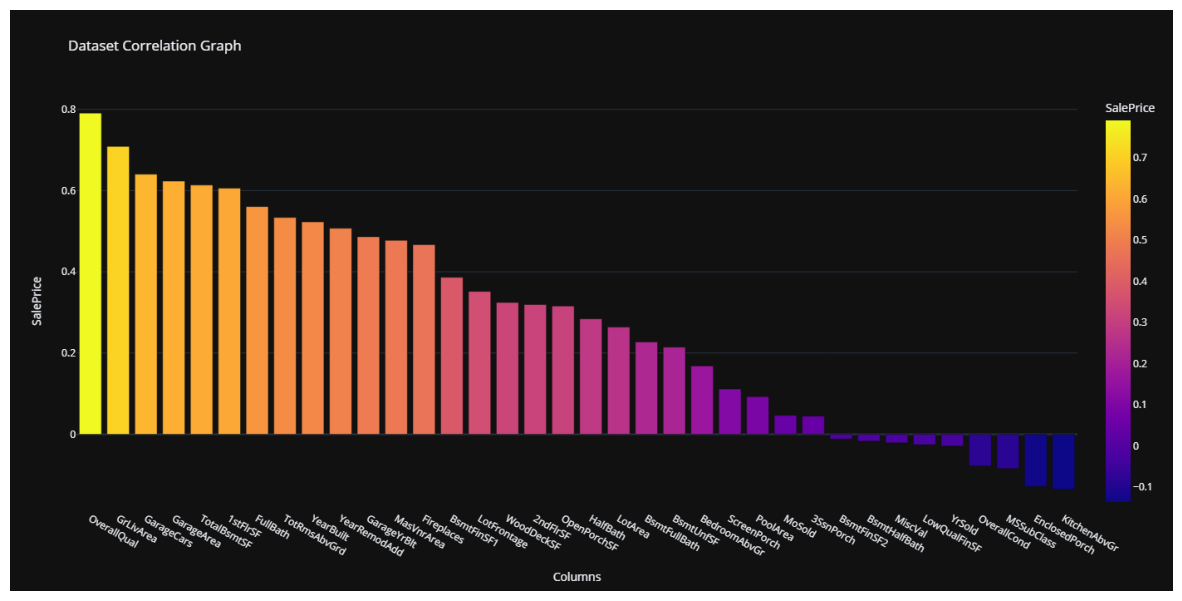

In [17]:
# GitHub only displays static images, so I saved the images and visualized them later.
corr_plot(train,target,'C:/Users/MahmutYAVUZ/Desktop/Software/Python/kaggle/regression/images/corr_plot.png')

In [18]:
missing_value_fill(train)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave    NH      Reg   
1        2          20       RL         80.0     9600   Pave    NH      Reg   
2        3          60       RL         68.0    11250   Pave    NH      IR1   
3        4          70       RL         60.0     9550   Pave    NH      IR1   
4        5          60       RL         84.0    14260   Pave    NH      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave    NH      Reg   
1456  1457          20       RL         85.0    13175   Pave    NH      Reg   
1457  1458          70       RL         66.0     9042   Pave    NH      Reg   
1458  1459          20       RL         68.0     9717   Pave    NH      Reg   
1459  1460          20       RL         75.0     9937   Pave    NH      Reg   

     LandContour Utilities  ... PoolQC  Fence MiscFeature MiscVal MoSold  \
0            Lvl    AllPub  ...     NH     NF          NH       0      2   
1            Lvl    AllPub  ...     NH     NF          NH       0      5   
2            Lvl    AllPub  ...     NH     NF          NH       0      9   
3            Lvl    AllPub  ...     NH     NF          NH       0      2   
4            Lvl    AllPub  ...     NH     NF          NH       0     12   
...          ...       ...  ...    ...    ...         ...     ...    ...   
1455         Lvl    AllPub  ...     NH     NF          NH       0      8   
1456         Lvl    AllPub  ...     NH  MnPrv          NH       0      2   
1457         Lvl    AllPub  ...     NH  GdPrv        Shed    2500      5   
1458         Lvl    AllPub  ...     NH     NF          NH       0      4   
1459         Lvl    AllPub  ...     NH     NF          NH       0      6   

     YrSold SaleType  SaleCondition  SalePrice  GarageRangeBuilt  
0      2008       WD         Normal     208500         2000-2004  
1      2007       WD         Normal     181500         1975-1979  
2      2008       WD         Normal     223500         2000-2004  
3      2006       WD        Abnorml     140000         1995-1999  
4      2008       WD         Normal     250000         2000-2004  
...     ...      ...            ...        ...               ...  
1455   2007       WD         Normal     175000         1995-1999  
1456   2010       WD         Normal     210000         1975-1979  
1457   2010       WD         Normal     266500         1940-1949  
1458   2010       WD         Normal     142125         1950-1954  
1459   2008       WD         Normal     147500         1965-1969  

[1460 rows x 82 columns]

In [19]:
train.drop('Id',axis=1,inplace=True)

In [20]:
ordinal_col = ['ExterCond','HeatingQC','ExterQual','KitchenQual','FireplaceQu','GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageRangeBuilt','OverallQual','OverallCond','KitchenQual','PoolQC']

In [21]:
cat_col = []
for i in train.columns.tolist():
    if len(train[i].unique())<30:
        if i not in ordinal_col:
            cat_col.append(i)

In [22]:
num_cols = [x for x in train.select_dtypes(include=['int','float']).columns.tolist() if x not in ordinal_col and x not in cat_col and x != 'SalePrice']

In [23]:
missing_num_cols = [x for x in train if train[x].isnull().sum() > 0 and x in num_cols]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('SalePrice', axis=1),
                                                    train['SalePrice'],
                                                    test_size=0.2,
                                                    random_state=33)
X_train,X_test = pipeline_build(X_train,X_test,missing_num_cols,ordinal_col,cat_col)
xgb_params = {
    'random_state': 33,
    'n_estimators': 1000,
    'max_depth': 8,
    'learning_rate': 0.01,
    'gamma': 0.2,
    'min_child_weight': 4,
    'subsample': 1,
    'colsample_bytree': 1
}

xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train, y_train)

print(f'RMSE : {np.sqrt(mean_squared_error(y_test, xgb.predict(X_test))):.4f}')
print(f'RMSLE : {mean_squared_log_error(y_test, xgb.predict(X_test)):.4f}')
print(f'R2 : {r2_score(y_test, xgb.predict(X_test)):.4f}')

RMSE : 30164.2315
RMSLE : 0.0220
R2 : 0.8530


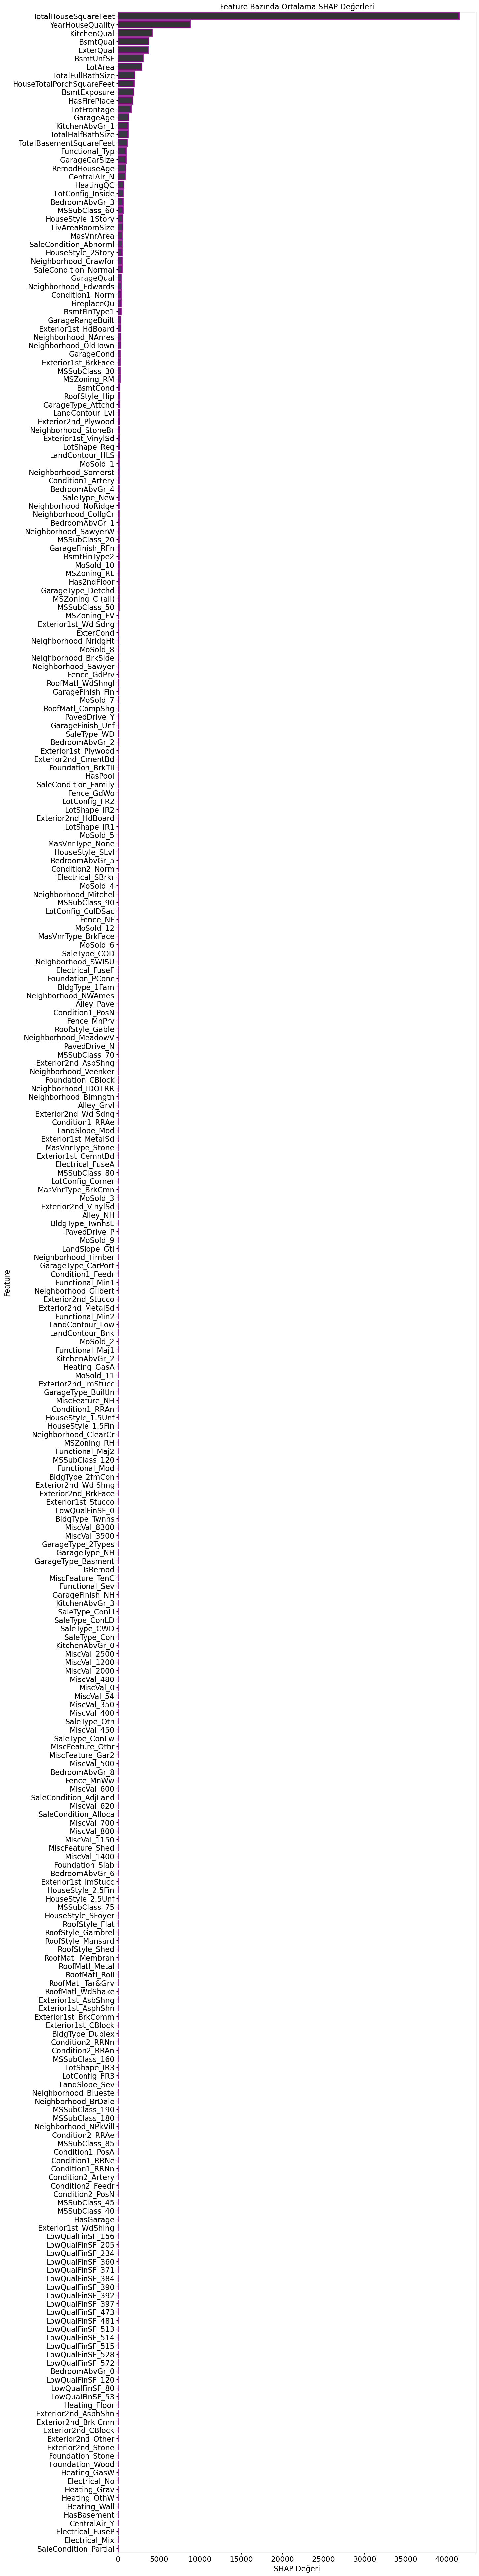

In [25]:
# Shap değerlerinin hesaplanması
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# Mutlak içine alınıp ortalama değerlerin bulunması
shap_values_mean_abs = np.abs(shap_values).mean(axis=0)
shap_values_df = pd.DataFrame(shap_values_mean_abs,
                              columns=['importance'],
                              index=X_test.columns)

# büyükten küçüğe sırala
shap_values_df.sort_values('importance', 
                           ascending=False,
                           inplace=True)
plt.figure(figsize=(14, 100))

sns.barplot(x='importance',
            y=shap_values_df.index,
            data=shap_values_df,
            palette="magma", orient='h',
            **{'edgecolor': 'purple', 'linewidth': 3, 'alpha': 0.8})

plt.xlabel('SHAP Değeri', fontsize=16)
plt.ylabel('Feature', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Feature Bazında Ortalama SHAP Değerleri', fontsize=16)
plt.show()

In [26]:
shap_values_df[:61]

importance
TotalHouseSquareFeet  41472.179688
YearHouseQuality       8844.348633
KitchenQual            4196.595703
BsmtQual               3741.776611
ExterQual              3700.483398
...                            ...
BedroomAbvGr_4          147.459946
SaleType_New            147.213028
Neighborhood_NoRidge    144.454849
Neighborhood_CollgCr    142.137695
BedroomAbvGr_1          137.711807

[61 rows x 1 columns]

In [27]:
shap_liste = shap_values_df[:61].index.tolist()

In [28]:
X_train_shap_columns = X_train[shap_liste]
X_test_shap_columns = X_test[shap_liste]

In [29]:
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train_shap_columns, X_test_shap_columns, y_train, y_test)

100%|██████████| 42/42 [00:17<00:00,  2.43it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 61
[LightGBM] [Info] Start training from score 180310.786815


In [30]:
models

Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                          0.86       0.89  26585.72   
LGBMRegressor                                0.85       0.88  27378.71   
GradientBoostingRegressor                    0.83       0.87  28417.98   
HistGradientBoostingRegressor                0.83       0.86  29168.30   
XGBRegressor                                 0.82       0.86  29399.27   
AdaBoostRegressor                            0.81       0.85  30244.81   
RandomForestRegressor                        0.77       0.82  33424.21   
BaggingRegressor                             0.77       0.82  33763.01   
TweedieRegressor                             0.66       0.73  40952.51   
ElasticNet                                   0.65       0.72  41483.55   
DecisionTreeRegressor                        0.64       0.72  41973.26   
HuberRegressor                               0.60       0.69  43997.11   
PassiveAggressiveRegressor                   0.60       0.68  44239.62   
BayesianRidge                                0.60       0.68  44270.26   
Ridge                                        0.59       0.68  44610.50   
RidgeCV                                      0.59       0.68  44610.50   
TransformedTargetRegressor                   0.59       0.68  44643.42   
LinearRegression                             0.59       0.68  44643.42   
LassoLars                                    0.59       0.68  44644.33   
Lasso                                        0.59       0.68  44644.34   
LassoLarsIC                                  0.59       0.68  44661.91   
SGDRegressor                                 0.59       0.68  44802.89   
LassoLarsCV                                  0.59       0.68  44806.86   
LassoCV                                      0.59       0.68  44809.84   
KNeighborsRegressor                          0.59       0.68  44820.23   
LarsCV                                       0.58       0.67  45066.28   
ExtraTreeRegressor                           0.56       0.65  46384.29   
Lars                                         0.44       0.56  52160.28   
OrthogonalMatchingPursuit                    0.41       0.53  53721.59   
OrthogonalMatchingPursuitCV                  0.41       0.53  53721.59   
RANSACRegressor                              0.33       0.47  57344.01   
ElasticNetCV                                -0.07       0.15  72476.09   
GammaRegressor                              -0.23       0.03  77634.38   
DummyRegressor                              -0.27      -0.00  78739.80   
NuSVR                                       -0.29      -0.02  79580.26   
SVR                                         -0.34      -0.06  81010.23   
QuantileRegressor                           -0.34      -0.06  81030.36   
PoissonRegressor                            -1.08      -0.64 100811.50   
KernelRidge                                 -6.05      -4.57 185747.59   
GaussianProcessRegressor                    -6.85      -5.21 196016.87   
MLPRegressor                                -6.90      -5.24 196616.48   
LinearSVR                                   -7.05      -5.36 198458.05   

                               Time Taken  
Model                                      
ExtraTreesRegressor                  1.33  
LGBMRegressor                        0.09  
GradientBoostingRegressor            0.52  
HistGradientBoostingRegressor        0.52  
XGBRegressor                         0.10  
AdaBoostRegressor                    0.19  
RandomForestRegressor                1.85  
BaggingRegressor                     0.20  
TweedieRegressor                     0.01  
ElasticNet                           0.01  
DecisionTreeRegressor                0.04  
HuberRegressor                       0.04  
PassiveAggressiveRegressor           0.17  
BayesianRidge                        0.03  
Ridge                                0.01  
RidgeCV                   

In [31]:
import catboost as cb

In [32]:
train_dataset = cb.Pool(X_train_shap_columns, y_train) 
test_dataset = cb.Pool(X_test_shap_columns, y_test)

In [33]:
model = cb.CatBoostRegressor(loss_function="RMSE")

In [34]:
model.fit(train_dataset,verbose = False)

In [35]:
print(f'RMSE : {np.sqrt(mean_squared_error(y_test, model.predict(test_dataset))):.4f}')
print(f'RMSLE : {mean_squared_log_error(y_test, model.predict(test_dataset)):.4f}')
print(f'R2 : {r2_score(y_test, model.predict(test_dataset)):.4f}')

RMSE : 23976.2858
RMSLE : 0.0205
R2 : 0.9071


In [36]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [37]:
shap_liste.append('SalePrice')

In [38]:
def objective(trial,X,y):   
    params = {
        'learning_rate': trial.suggest_float('learning_rate',0.0005, 0.5,step=0.01),
        'n_estimators': trial.suggest_int('n_estimators',0, 3000,step=10),
        'max_bin': trial.suggest_int('max_bin',16, 2048,step=16),
        'subsample': trial.suggest_float('subsample', 0.1, 1,step=0.1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1, step=0.1),
        'loss_function' : 'RMSE',
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'random_seed': 33,
        'verbose': False
    }
    liste = []  
    for fold_no, (train_index, test_index) in enumerate(kf.split(X,y)):
        print(fold_no)
        # Train ve validasyon setlerini alıyoruz.
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = cb.CatBoostRegressor(**params)
        model.fit(X_train, y_train)
        print(f'RMSE : {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.4f}')
        liste.append(np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    return np.mean(liste)

In [39]:
study = optuna.create_study(direction = 'minimize')
study.optimize(lambda trial: objective(trial, X_train_shap_columns, y_train), n_trials = 100)

[I 2023-09-14 07:29:33,881] A new study created in memory with name: no-name-0db8cb03-fd66-4170-9c52-072eeabe115b


0
RMSE : 30867.3724
1
RMSE : 28439.1825
2
RMSE : 30655.5440
3
RMSE : 36712.5994
4


[I 2023-09-14 07:29:37,751] Trial 0 finished with value: 31515.33169420855 and parameters: {'learning_rate': 0.4605, 'n_estimators': 760, 'max_bin': 192, 'subsample': 0.5, 'colsample_bylevel': 0.1, 'max_depth': 6}. Best is trial 0 with value: 31515.33169420855.


RMSE : 30901.9602
0
RMSE : 31212.3827
1
RMSE : 27705.6742
2
RMSE : 30313.6176
3
RMSE : 38892.9975
4


[I 2023-09-14 07:29:43,335] Trial 1 finished with value: 31885.614253553795 and parameters: {'learning_rate': 0.4205, 'n_estimators': 860, 'max_bin': 1536, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.1, 'max_depth': 6}. Best is trial 0 with value: 31515.33169420855.


RMSE : 31303.3993
0
RMSE : 30035.7641
1
RMSE : 25344.6599
2
RMSE : 30042.6358
3
RMSE : 42716.8245
4


[I 2023-09-14 07:29:54,777] Trial 2 finished with value: 31545.198295852682 and parameters: {'learning_rate': 0.3405, 'n_estimators': 1670, 'max_bin': 432, 'subsample': 0.9, 'colsample_bylevel': 0.2, 'max_depth': 6}. Best is trial 0 with value: 31515.33169420855.


RMSE : 29586.1072
0
RMSE : 31656.3453
1
RMSE : 24827.0424
2
RMSE : 29041.5331
3
RMSE : 35206.6517
4


[I 2023-09-14 07:31:02,028] Trial 3 finished with value: 29557.621297227033 and parameters: {'learning_rate': 0.0105, 'n_estimators': 1210, 'max_bin': 880, 'subsample': 0.4, 'colsample_bylevel': 0.4, 'max_depth': 8}. Best is trial 3 with value: 29557.621297227033.


RMSE : 27056.5340
0
RMSE : 31276.1517
1
RMSE : 24170.9338
2
RMSE : 28598.6423
3
RMSE : 36356.4173
4


[I 2023-09-14 07:31:19,054] Trial 4 finished with value: 29264.189717677342 and parameters: {'learning_rate': 0.1205, 'n_estimators': 3000, 'max_bin': 80, 'subsample': 0.1, 'colsample_bylevel': 0.30000000000000004, 'max_depth': 6}. Best is trial 4 with value: 29264.189717677342.


RMSE : 25918.8035
0
RMSE : 35224.5815
1
RMSE : 26173.8838
2
RMSE : 33520.7402
3
RMSE : 40367.4787
4


[I 2023-09-14 07:31:37,337] Trial 5 finished with value: 32677.24524635588 and parameters: {'learning_rate': 0.2505, 'n_estimators': 90, 'max_bin': 432, 'subsample': 0.4, 'colsample_bylevel': 0.2, 'max_depth': 10}. Best is trial 4 with value: 29264.189717677342.


RMSE : 28099.5420
0
RMSE : 28536.3727
1
RMSE : 26028.2943
2
RMSE : 28090.7970
3
RMSE : 38018.0603
4


[I 2023-09-14 07:31:56,702] Trial 6 finished with value: 29485.214146244427 and parameters: {'learning_rate': 0.1005, 'n_estimators': 2080, 'max_bin': 544, 'subsample': 1.0, 'colsample_bylevel': 0.6, 'max_depth': 6}. Best is trial 4 with value: 29264.189717677342.


RMSE : 26752.5465
0
RMSE : 31781.3605
1
RMSE : 24501.1165
2
RMSE : 30295.8241
3
RMSE : 36398.3125
4


[I 2023-09-14 07:32:03,941] Trial 7 finished with value: 30077.93162668308 and parameters: {'learning_rate': 0.2205, 'n_estimators': 490, 'max_bin': 1936, 'subsample': 0.8, 'colsample_bylevel': 1.0, 'max_depth': 7}. Best is trial 4 with value: 29264.189717677342.


RMSE : 27413.0445
0
RMSE : 32138.0564
1
RMSE : 25047.5964
2
RMSE : 30336.8908
3
RMSE : 40115.7474
4


[I 2023-09-14 07:32:07,470] Trial 8 finished with value: 30862.839475523804 and parameters: {'learning_rate': 0.47050000000000003, 'n_estimators': 310, 'max_bin': 2032, 'subsample': 0.1, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 4 with value: 29264.189717677342.


RMSE : 26675.9064
0
RMSE : 80652.4408
1
RMSE : 72090.6689
2
RMSE : 70289.8302
3
RMSE : 81324.3768
4


[I 2023-09-14 07:32:10,597] Trial 9 finished with value: 75743.77283901421 and parameters: {'learning_rate': 0.0005, 'n_estimators': 190, 'max_bin': 1200, 'subsample': 0.1, 'colsample_bylevel': 1.0, 'max_depth': 7}. Best is trial 4 with value: 29264.189717677342.


RMSE : 74361.5476
0
RMSE : 36311.1174
1
RMSE : 30022.7995
2
RMSE : 32210.8620
3
RMSE : 35213.8380
4


[I 2023-09-14 07:38:24,447] Trial 10 finished with value: 32458.226244442143 and parameters: {'learning_rate': 0.1405, 'n_estimators': 2980, 'max_bin': 16, 'subsample': 0.7000000000000001, 'colsample_bylevel': 0.4, 'max_depth': 10}. Best is trial 4 with value: 29264.189717677342.


RMSE : 28532.5144
0
RMSE : 32371.0752
1
RMSE : 24239.9790
2
RMSE : 29990.5877
3
RMSE : 37417.4704
4


[I 2023-09-14 07:41:08,199] Trial 11 finished with value: 30461.783514525265 and parameters: {'learning_rate': 0.1105, 'n_estimators': 2850, 'max_bin': 688, 'subsample': 1.0, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 8}. Best is trial 4 with value: 29264.189717677342.


RMSE : 28289.8052
0
RMSE : 32072.6910
1
RMSE : 24166.4687
2
RMSE : 28156.9784
3
RMSE : 36840.5634
4


[I 2023-09-14 07:41:38,355] Trial 12 finished with value: 29485.474225264952 and parameters: {'learning_rate': 0.1005, 'n_estimators': 2190, 'max_bin': 464, 'subsample': 0.7000000000000001, 'colsample_bylevel': 0.5, 'max_depth': 7}. Best is trial 4 with value: 29264.189717677342.


RMSE : 26190.6697
0
RMSE : 33451.3651
1
RMSE : 25898.1290
2
RMSE : 30816.3825
3
RMSE : 35676.8334
4


[I 2023-09-14 07:42:38,341] Trial 13 finished with value: 31138.144881063985 and parameters: {'learning_rate': 0.1905, 'n_estimators': 2400, 'max_bin': 80, 'subsample': 0.2, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 9}. Best is trial 4 with value: 29264.189717677342.


RMSE : 29848.0144
0
RMSE : 30685.6596
1
RMSE : 23904.5522
2
RMSE : 28268.9927
3
RMSE : 36124.1202
4


[I 2023-09-14 07:43:22,274] Trial 14 finished with value: 28981.876852932775 and parameters: {'learning_rate': 0.0605, 'n_estimators': 2070, 'max_bin': 1088, 'subsample': 0.6, 'colsample_bylevel': 0.5, 'max_depth': 7}. Best is trial 14 with value: 28981.876852932775.


RMSE : 25926.0596
0
RMSE : 29387.1094
1
RMSE : 23975.8980
2
RMSE : 27842.1671
3
RMSE : 35643.4720
4


[I 2023-09-14 07:44:08,879] Trial 15 finished with value: 28698.136790451408 and parameters: {'learning_rate': 0.0505, 'n_estimators': 2600, 'max_bin': 1248, 'subsample': 0.6, 'colsample_bylevel': 0.30000000000000004, 'max_depth': 7}. Best is trial 15 with value: 28698.136790451408.


RMSE : 26642.0374
0
RMSE : 31471.8296
1
RMSE : 24138.0045
2
RMSE : 28886.5641
3
RMSE : 35957.5274
4


[I 2023-09-14 07:44:43,458] Trial 16 finished with value: 29538.11763787053 and parameters: {'learning_rate': 0.0505, 'n_estimators': 1710, 'max_bin': 1184, 'subsample': 0.6, 'colsample_bylevel': 0.5, 'max_depth': 7}. Best is trial 15 with value: 28698.136790451408.


RMSE : 27236.6626
0
RMSE : 36188.5747
1
RMSE : 28208.4040
2
RMSE : 32097.6400
3
RMSE : 40404.3427
4


[I 2023-09-14 07:50:25,602] Trial 17 finished with value: 33393.84287399657 and parameters: {'learning_rate': 0.2905, 'n_estimators': 2440, 'max_bin': 1488, 'subsample': 0.6, 'colsample_bylevel': 0.30000000000000004, 'max_depth': 9}. Best is trial 15 with value: 28698.136790451408.


RMSE : 30070.2529
0
RMSE : 29933.8675
1
RMSE : 24369.0154
2
RMSE : 28946.6022
3
RMSE : 36823.0316
4


[I 2023-09-14 07:52:51,424] Trial 18 finished with value: 29345.023082854343 and parameters: {'learning_rate': 0.0505, 'n_estimators': 2620, 'max_bin': 1488, 'subsample': 0.5, 'colsample_bylevel': 0.8, 'max_depth': 8}. Best is trial 15 with value: 28698.136790451408.


RMSE : 26652.5986
0
RMSE : 31365.0589
1
RMSE : 27696.7650
2
RMSE : 27848.2184
3
RMSE : 38198.2817
4


[I 2023-09-14 07:53:30,648] Trial 19 finished with value: 30491.92346721544 and parameters: {'learning_rate': 0.1605, 'n_estimators': 2010, 'max_bin': 1024, 'subsample': 0.8, 'colsample_bylevel': 0.4, 'max_depth': 7}. Best is trial 15 with value: 28698.136790451408.


RMSE : 27351.2934
0
RMSE : 31588.1753
1
RMSE : 25769.2751
2
RMSE : 30067.8011
3
RMSE : 35196.7005
4


[I 2023-09-14 07:56:51,652] Trial 20 finished with value: 29990.243036409385 and parameters: {'learning_rate': 0.0605, 'n_estimators': 1270, 'max_bin': 1728, 'subsample': 0.7000000000000001, 'colsample_bylevel': 0.6, 'max_depth': 9}. Best is trial 15 with value: 28698.136790451408.


RMSE : 27329.2631
0
RMSE : 30140.1895
1
RMSE : 24452.6687
2
RMSE : 28779.8918
3
RMSE : 35904.9313
4


[I 2023-09-14 07:57:39,973] Trial 21 finished with value: 29071.647771344153 and parameters: {'learning_rate': 0.07050000000000001, 'n_estimators': 2710, 'max_bin': 928, 'subsample': 0.4, 'colsample_bylevel': 0.30000000000000004, 'max_depth': 7}. Best is trial 15 with value: 28698.136790451408.


RMSE : 26080.5576
0
RMSE : 30231.4204
1
RMSE : 24748.6509
2
RMSE : 27883.2300
3
RMSE : 35145.7334
4


[I 2023-09-14 07:58:25,757] Trial 22 finished with value: 28958.232260247554 and parameters: {'learning_rate': 0.0405, 'n_estimators': 2590, 'max_bin': 1232, 'subsample': 0.4, 'colsample_bylevel': 0.30000000000000004, 'max_depth': 7}. Best is trial 15 with value: 28698.136790451408.


RMSE : 26782.1266
0
RMSE : 54787.5028
1
RMSE : 47233.5029
2
RMSE : 47598.9284
3
RMSE : 53451.1762
4


[I 2023-09-14 08:00:07,577] Trial 23 finished with value: 49946.849299058755 and parameters: {'learning_rate': 0.0005, 'n_estimators': 2370, 'max_bin': 1264, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.2, 'max_depth': 8}. Best is trial 15 with value: 28698.136790451408.


RMSE : 46663.1362
0
RMSE : 32596.2779
1
RMSE : 24821.5294
2
RMSE : 29002.1169
3
RMSE : 38661.3908
4


[I 2023-09-14 08:00:43,343] Trial 24 finished with value: 30500.133279295842 and parameters: {'learning_rate': 0.1905, 'n_estimators': 1840, 'max_bin': 1344, 'subsample': 0.5, 'colsample_bylevel': 0.4, 'max_depth': 7}. Best is trial 15 with value: 28698.136790451408.


RMSE : 27419.3514
0
RMSE : 30942.5973
1
RMSE : 24291.1446
2
RMSE : 28225.9277
3
RMSE : 35966.4728
4


[I 2023-09-14 08:01:36,979] Trial 25 finished with value: 29091.088751212425 and parameters: {'learning_rate': 0.0405, 'n_estimators': 2640, 'max_bin': 832, 'subsample': 0.6, 'colsample_bylevel': 0.5, 'max_depth': 7}. Best is trial 15 with value: 28698.136790451408.


RMSE : 26029.3014
0
RMSE : 34188.0056
1
RMSE : 24604.8932
2
RMSE : 29657.6776
3
RMSE : 35005.2677
4


[I 2023-09-14 08:03:29,437] Trial 26 finished with value: 30094.293390498562 and parameters: {'learning_rate': 0.1605, 'n_estimators': 2190, 'max_bin': 1072, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.30000000000000004, 'max_depth': 8}. Best is trial 15 with value: 28698.136790451408.


RMSE : 27015.6229
0
RMSE : 29983.6125
1
RMSE : 28349.6877
2
RMSE : 32586.2666
3
RMSE : 34062.3823
4


[I 2023-09-14 08:03:51,001] Trial 27 finished with value: 30455.328087008755 and parameters: {'learning_rate': 0.3305, 'n_estimators': 1390, 'max_bin': 1696, 'subsample': 0.5, 'colsample_bylevel': 0.2, 'max_depth': 7}. Best is trial 15 with value: 28698.136790451408.


RMSE : 27294.6913
0
RMSE : 31300.5123
1
RMSE : 25329.6189
2
RMSE : 28493.0915
3
RMSE : 35548.4865
4


[I 2023-09-14 08:05:38,817] Trial 28 finished with value: 29506.92906046011 and parameters: {'learning_rate': 0.07050000000000001, 'n_estimators': 1910, 'max_bin': 1392, 'subsample': 0.8, 'colsample_bylevel': 0.4, 'max_depth': 8}. Best is trial 15 with value: 28698.136790451408.


RMSE : 26862.9361
0
RMSE : 33864.0094
1
RMSE : 27878.4348
2
RMSE : 31228.6002
3
RMSE : 37149.1165
4


[I 2023-09-14 08:05:54,934] Trial 29 finished with value: 31959.258787179326 and parameters: {'learning_rate': 0.4205, 'n_estimators': 2530, 'max_bin': 1088, 'subsample': 0.4, 'colsample_bylevel': 0.1, 'max_depth': 6}. Best is trial 15 with value: 28698.136790451408.


RMSE : 29676.1330
0
RMSE : 29930.8033
1
RMSE : 24701.1203
2
RMSE : 27837.7403
3
RMSE : 36030.1938
4


[I 2023-09-14 08:06:42,228] Trial 30 finished with value: 28901.647261416907 and parameters: {'learning_rate': 0.0205, 'n_estimators': 2270, 'max_bin': 1696, 'subsample': 0.6, 'colsample_bylevel': 0.6, 'max_depth': 7}. Best is trial 15 with value: 28698.136790451408.


RMSE : 26008.3785
0
RMSE : 29081.4654
1
RMSE : 25757.0631
2
RMSE : 28045.4469
3
RMSE : 36844.0171
4


[I 2023-09-14 08:07:28,904] Trial 31 finished with value: 29160.731327492114 and parameters: {'learning_rate': 0.0305, 'n_estimators': 2280, 'max_bin': 1680, 'subsample': 0.6, 'colsample_bylevel': 0.8, 'max_depth': 7}. Best is trial 15 with value: 28698.136790451408.


RMSE : 26075.6641
0
RMSE : 31785.5537
1
RMSE : 24091.7913
2
RMSE : 27999.3862
3
RMSE : 36767.7047
4


[I 2023-09-14 08:08:25,758] Trial 32 finished with value: 29359.84674586851 and parameters: {'learning_rate': 0.0805, 'n_estimators': 2780, 'max_bin': 1872, 'subsample': 0.7000000000000001, 'colsample_bylevel': 0.5, 'max_depth': 7}. Best is trial 15 with value: 28698.136790451408.


RMSE : 26154.7979
0
RMSE : 28541.2461
1
RMSE : 23564.6789
2
RMSE : 26866.4078
3
RMSE : 37878.4914
4


[I 2023-09-14 08:08:42,573] Trial 33 finished with value: 28435.909645709722 and parameters: {'learning_rate': 0.0205, 'n_estimators': 1590, 'max_bin': 736, 'subsample': 0.5, 'colsample_bylevel': 0.6, 'max_depth': 6}. Best is trial 33 with value: 28435.909645709722.


RMSE : 25328.7240
0
RMSE : 28576.0316
1
RMSE : 23609.9794
2
RMSE : 27473.8068
3
RMSE : 35761.8933
4


[I 2023-09-14 08:09:00,327] Trial 34 finished with value: 28257.333618278142 and parameters: {'learning_rate': 0.0205, 'n_estimators': 1690, 'max_bin': 704, 'subsample': 0.4, 'colsample_bylevel': 0.6, 'max_depth': 6}. Best is trial 34 with value: 28257.333618278142.


RMSE : 25864.9570
0
RMSE : 29046.4591
1
RMSE : 23741.4333
2
RMSE : 27619.2314
3
RMSE : 37691.5019
4


[I 2023-09-14 08:09:10,168] Trial 35 finished with value: 28842.4434763363 and parameters: {'learning_rate': 0.0205, 'n_estimators': 960, 'max_bin': 656, 'subsample': 0.5, 'colsample_bylevel': 0.6, 'max_depth': 6}. Best is trial 34 with value: 28257.333618278142.


RMSE : 26113.5916
0
RMSE : 29419.0978
1
RMSE : 24995.9579
2
RMSE : 28603.5973
3
RMSE : 38232.6823
4


[I 2023-09-14 08:09:18,210] Trial 36 finished with value: 29618.715252857208 and parameters: {'learning_rate': 0.0105, 'n_estimators': 970, 'max_bin': 288, 'subsample': 0.5, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 34 with value: 28257.333618278142.


RMSE : 26842.2410
0
RMSE : 29122.2962
1
RMSE : 25004.8051
2
RMSE : 27853.8893
3
RMSE : 36170.5863
4


[I 2023-09-14 08:09:29,259] Trial 37 finished with value: 28879.784861827495 and parameters: {'learning_rate': 0.1205, 'n_estimators': 1030, 'max_bin': 704, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.6, 'max_depth': 6}. Best is trial 34 with value: 28257.333618278142.


RMSE : 26247.3474
0
RMSE : 72010.6681
1
RMSE : 63842.5158
2
RMSE : 62678.3159
3
RMSE : 71815.1835
4


[I 2023-09-14 08:09:35,827] Trial 38 finished with value: 67098.39610721824 and parameters: {'learning_rate': 0.0005, 'n_estimators': 650, 'max_bin': 656, 'subsample': 0.2, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 34 with value: 28257.333618278142.


RMSE : 65145.2973
0
RMSE : 31416.3114
1
RMSE : 23185.5768
2
RMSE : 27529.8123
3
RMSE : 38025.0328
4


[I 2023-09-14 08:09:48,270] Trial 39 finished with value: 29564.744798306398 and parameters: {'learning_rate': 0.0905, 'n_estimators': 1520, 'max_bin': 272, 'subsample': 0.5, 'colsample_bylevel': 0.9, 'max_depth': 6}. Best is trial 34 with value: 28257.333618278142.


RMSE : 27666.9907
0
RMSE : 27850.1543
1
RMSE : 25820.5087
2
RMSE : 28028.2770
3
RMSE : 38466.4712
4


[I 2023-09-14 08:10:04,993] Trial 40 finished with value: 29042.648845851578 and parameters: {'learning_rate': 0.1305, 'n_estimators': 1580, 'max_bin': 800, 'subsample': 0.4, 'colsample_bylevel': 0.6, 'max_depth': 6}. Best is trial 34 with value: 28257.333618278142.


RMSE : 25047.8330
0
RMSE : 28195.7073
1
RMSE : 22822.9465
2
RMSE : 27367.4889
3
RMSE : 36700.1880
4


[I 2023-09-14 08:10:16,199] Trial 41 finished with value: 28111.29086280946 and parameters: {'learning_rate': 0.0305, 'n_estimators': 1080, 'max_bin': 656, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.6, 'max_depth': 6}. Best is trial 41 with value: 28111.29086280946.


RMSE : 25470.1237
0
RMSE : 28897.6054
1
RMSE : 23522.1407
2
RMSE : 27133.1902
3
RMSE : 36625.7252
4


[I 2023-09-14 08:10:27,073] Trial 42 finished with value: 28449.620231439672 and parameters: {'learning_rate': 0.0405, 'n_estimators': 1130, 'max_bin': 528, 'subsample': 0.2, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 41 with value: 28111.29086280946.


RMSE : 26069.4398
0
RMSE : 28202.4132
1
RMSE : 23176.6939
2
RMSE : 27396.3048
3
RMSE : 36815.0371
4


[I 2023-09-14 08:10:37,945] Trial 43 finished with value: 28295.87638977386 and parameters: {'learning_rate': 0.0305, 'n_estimators': 1110, 'max_bin': 544, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 41 with value: 28111.29086280946.


RMSE : 25888.9329
0
RMSE : 29643.5044
1
RMSE : 23538.1498
2
RMSE : 26613.6549
3
RMSE : 36650.3722
4


[I 2023-09-14 08:10:49,397] Trial 44 finished with value: 28448.93371488399 and parameters: {'learning_rate': 0.0305, 'n_estimators': 1160, 'max_bin': 544, 'subsample': 0.2, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 41 with value: 28111.29086280946.


RMSE : 25798.9873
0
RMSE : 30277.1367
1
RMSE : 25069.8022
2
RMSE : 27206.8688
3
RMSE : 38870.6357
4


[I 2023-09-14 08:11:03,084] Trial 45 finished with value: 29365.54586061657 and parameters: {'learning_rate': 0.0905, 'n_estimators': 1370, 'max_bin': 576, 'subsample': 0.2, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 41 with value: 28111.29086280946.


RMSE : 25403.2859
0
RMSE : 69723.2550
1
RMSE : 61569.3225
2
RMSE : 60689.4942
3
RMSE : 69280.6408
4


[I 2023-09-14 08:11:10,186] Trial 46 finished with value: 64796.09581364484 and parameters: {'learning_rate': 0.0005, 'n_estimators': 780, 'max_bin': 448, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 41 with value: 28111.29086280946.


RMSE : 62717.7665
0
RMSE : 29293.2071
1
RMSE : 23717.1435
2
RMSE : 27377.7171
3
RMSE : 37015.2292
4


[I 2023-09-14 08:11:20,402] Trial 47 finished with value: 28581.08322645881 and parameters: {'learning_rate': 0.0205, 'n_estimators': 1180, 'max_bin': 368, 'subsample': 0.1, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 41 with value: 28111.29086280946.


RMSE : 25502.1193
0
RMSE : 30147.0133
1
RMSE : 23006.8850
2
RMSE : 27907.2412
3
RMSE : 37292.8881
4


[I 2023-09-14 08:11:34,748] Trial 48 finished with value: 28786.10911031458 and parameters: {'learning_rate': 0.1005, 'n_estimators': 1370, 'max_bin': 752, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.9, 'max_depth': 6}. Best is trial 41 with value: 28111.29086280946.


RMSE : 25576.5179
0
RMSE : 29742.5437
1
RMSE : 26625.2988
2
RMSE : 27797.3212
3
RMSE : 38874.2062
4


[I 2023-09-14 08:11:53,043] Trial 49 finished with value: 29964.418800385938 and parameters: {'learning_rate': 0.2505, 'n_estimators': 1690, 'max_bin': 928, 'subsample': 0.2, 'colsample_bylevel': 0.6, 'max_depth': 6}. Best is trial 41 with value: 28111.29086280946.


RMSE : 26782.7241
0
RMSE : 31929.7680
1
RMSE : 27123.7905
2
RMSE : 29554.9756
3
RMSE : 39487.8409
4


[I 2023-09-14 08:11:59,554] Trial 50 finished with value: 31405.959649880784 and parameters: {'learning_rate': 0.3805, 'n_estimators': 680, 'max_bin': 560, 'subsample': 0.4, 'colsample_bylevel': 0.9, 'max_depth': 6}. Best is trial 41 with value: 28111.29086280946.


RMSE : 28933.4232
0
RMSE : 29682.1352
1
RMSE : 25820.9016
2
RMSE : 32348.7068
3
RMSE : 39638.1945
4


[I 2023-09-14 08:12:10,054] Trial 51 finished with value: 31292.928647599496 and parameters: {'learning_rate': 0.4905, 'n_estimators': 1110, 'max_bin': 496, 'subsample': 0.2, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 41 with value: 28111.29086280946.


RMSE : 28974.7051
0
RMSE : 29440.9479
1
RMSE : 23637.9820
2
RMSE : 27060.0699
3
RMSE : 37107.6900
4


[I 2023-09-14 08:12:17,179] Trial 52 finished with value: 28628.897025045 and parameters: {'learning_rate': 0.0305, 'n_estimators': 840, 'max_bin': 384, 'subsample': 0.1, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 41 with value: 28111.29086280946.


RMSE : 25897.7954
0
RMSE : 29075.8027
1
RMSE : 24770.3847
2
RMSE : 27863.4566
3
RMSE : 39009.1618
4


[I 2023-09-14 08:12:29,584] Trial 53 finished with value: 29418.380328681356 and parameters: {'learning_rate': 0.07050000000000001, 'n_estimators': 1260, 'max_bin': 592, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 41 with value: 28111.29086280946.


RMSE : 26373.0958
0
RMSE : 28053.9596
1
RMSE : 22090.5029
2
RMSE : 26941.2411
3
RMSE : 36725.3652
4


[I 2023-09-14 08:12:36,874] Trial 54 finished with value: 27721.099423436775 and parameters: {'learning_rate': 0.0405, 'n_estimators': 1070, 'max_bin': 192, 'subsample': 0.2, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 24794.4283
0
RMSE : 32928.3280
1
RMSE : 25960.0431
2
RMSE : 32030.2651
3
RMSE : 36109.9193
4


[I 2023-09-14 08:13:33,782] Trial 55 finished with value: 31043.60263406176 and parameters: {'learning_rate': 0.0605, 'n_estimators': 490, 'max_bin': 128, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.6, 'max_depth': 10}. Best is trial 54 with value: 27721.099423436775.


RMSE : 28189.4576
0
RMSE : 29430.3053
1
RMSE : 24154.3646
2
RMSE : 27323.9705
3
RMSE : 37726.3458
4


[I 2023-09-14 08:13:45,731] Trial 56 finished with value: 28834.833890436636 and parameters: {'learning_rate': 0.1505, 'n_estimators': 1790, 'max_bin': 224, 'subsample': 0.2, 'colsample_bylevel': 0.5, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25539.1833
0
RMSE : 30134.4179
1
RMSE : 23196.8794
2
RMSE : 27088.2098
3
RMSE : 36798.6775
4


[I 2023-09-14 08:13:58,082] Trial 57 finished with value: 28784.306608287443 and parameters: {'learning_rate': 0.1105, 'n_estimators': 1560, 'max_bin': 352, 'subsample': 0.1, 'colsample_bylevel': 0.6, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26703.3485
0
RMSE : 31200.5174
1
RMSE : 26271.2262
2
RMSE : 28620.5178
3
RMSE : 36984.4929
4


[I 2023-09-14 08:14:15,503] Trial 58 finished with value: 29855.93324579865 and parameters: {'learning_rate': 0.2805, 'n_estimators': 1460, 'max_bin': 864, 'subsample': 0.4, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26202.9120
0
RMSE : 28328.2498
1
RMSE : 23573.4987
2
RMSE : 27371.6783
3
RMSE : 36862.3206
4


[I 2023-09-14 08:14:26,063] Trial 59 finished with value: 28390.99145554732 and parameters: {'learning_rate': 0.0205, 'n_estimators': 910, 'max_bin': 992, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25819.2098
0
RMSE : 31433.7446
1
RMSE : 25282.2254
2
RMSE : 30726.5468
3
RMSE : 33540.4826
4


[I 2023-09-14 08:15:49,434] Trial 60 finished with value: 29623.95697768922 and parameters: {'learning_rate': 0.0505, 'n_estimators': 540, 'max_bin': 976, 'subsample': 0.4, 'colsample_bylevel': 0.5, 'max_depth': 9}. Best is trial 54 with value: 27721.099423436775.


RMSE : 27136.7854
0
RMSE : 28306.0775
1
RMSE : 23541.9167
2
RMSE : 27362.5294
3
RMSE : 36859.0822
4


[I 2023-09-14 08:15:59,804] Trial 61 finished with value: 28373.834077875577 and parameters: {'learning_rate': 0.0205, 'n_estimators': 930, 'max_bin': 752, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25799.5646
0
RMSE : 29735.8097
1
RMSE : 24947.5166
2
RMSE : 28339.9122
3
RMSE : 37149.0952
4


[I 2023-09-14 08:16:09,821] Trial 62 finished with value: 29331.675529310964 and parameters: {'learning_rate': 0.0105, 'n_estimators': 910, 'max_bin': 736, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.6, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26486.0440
0
RMSE : 29420.2444
1
RMSE : 24110.0844
2
RMSE : 27769.2921
3
RMSE : 36385.4579
4


[I 2023-09-14 08:16:20,771] Trial 63 finished with value: 28765.79674732207 and parameters: {'learning_rate': 0.0805, 'n_estimators': 1050, 'max_bin': 640, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26143.9049
0
RMSE : 29174.2966
1
RMSE : 24193.9326
2
RMSE : 27009.3520
3
RMSE : 36170.6601
4


[I 2023-09-14 08:16:34,981] Trial 64 finished with value: 28334.507291261776 and parameters: {'learning_rate': 0.0405, 'n_estimators': 1280, 'max_bin': 800, 'subsample': 0.4, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25124.2952
0
RMSE : 28821.7720
1
RMSE : 23170.1648
2
RMSE : 27125.8188
3
RMSE : 37449.4592
4


[I 2023-09-14 08:16:48,939] Trial 65 finished with value: 28218.327625785558 and parameters: {'learning_rate': 0.0405, 'n_estimators': 1270, 'max_bin': 784, 'subsample': 0.4, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 24524.4234
0
RMSE : 29088.2878
1
RMSE : 24381.9579
2
RMSE : 27711.8423
3
RMSE : 36604.2315
4


[I 2023-09-14 08:17:16,093] Trial 66 finished with value: 28761.769647277408 and parameters: {'learning_rate': 0.0505, 'n_estimators': 1320, 'max_bin': 800, 'subsample': 0.4, 'colsample_bylevel': 0.8, 'max_depth': 7}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26022.5288
0
RMSE : 29989.1226
1
RMSE : 24011.6705
2
RMSE : 26792.7894
3
RMSE : 36746.7733
4


[I 2023-09-14 08:17:31,256] Trial 67 finished with value: 28703.416427326138 and parameters: {'learning_rate': 0.0605, 'n_estimators': 1440, 'max_bin': 912, 'subsample': 0.4, 'colsample_bylevel': 0.9, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25976.7264
0
RMSE : 28826.8715
1
RMSE : 23162.7208
2
RMSE : 27126.0922
3
RMSE : 37444.7946
4


[I 2023-09-14 08:17:44,784] Trial 68 finished with value: 28216.21043625605 and parameters: {'learning_rate': 0.0405, 'n_estimators': 1250, 'max_bin': 800, 'subsample': 0.4, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 24520.5731
0
RMSE : 29897.0559
1
RMSE : 23964.9020
2
RMSE : 28129.2946
3
RMSE : 38789.9765
4


[I 2023-09-14 08:18:10,411] Trial 69 finished with value: 29239.882649060783 and parameters: {'learning_rate': 0.0405, 'n_estimators': 1250, 'max_bin': 816, 'subsample': 0.4, 'colsample_bylevel': 0.8, 'max_depth': 7}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25418.1842
0
RMSE : 30310.8607
1
RMSE : 24789.9057
2
RMSE : 27337.4950
3
RMSE : 37534.0027
4


[I 2023-09-14 08:18:20,656] Trial 70 finished with value: 29257.706271622486 and parameters: {'learning_rate': 0.2205, 'n_estimators': 1030, 'max_bin': 624, 'subsample': 0.4, 'colsample_bylevel': 0.9, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26316.2673
0
RMSE : 69460.7151
1
RMSE : 61453.4783
2
RMSE : 60507.2307
3
RMSE : 69075.4377
4


[I 2023-09-14 08:18:29,090] Trial 71 finished with value: 64586.4995672271 and parameters: {'learning_rate': 0.0005, 'n_estimators': 790, 'max_bin': 864, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 62435.6359
0
RMSE : 29030.6631
1
RMSE : 24497.7048
2
RMSE : 27034.7116
3
RMSE : 37697.9058
4


[I 2023-09-14 08:18:41,036] Trial 72 finished with value: 28748.68913474359 and parameters: {'learning_rate': 0.07050000000000001, 'n_estimators': 1100, 'max_bin': 1136, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25482.4603
0
RMSE : 28812.8839
1
RMSE : 23146.6331
2
RMSE : 27124.7196
3
RMSE : 37463.6067
4


[I 2023-09-14 08:18:55,490] Trial 73 finished with value: 28210.41660594709 and parameters: {'learning_rate': 0.0405, 'n_estimators': 1210, 'max_bin': 768, 'subsample': 0.4, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 24504.2398
0
RMSE : 27816.0042
1
RMSE : 23756.0429
2
RMSE : 26977.9047
3
RMSE : 38700.6472
4


[I 2023-09-14 08:19:06,895] Trial 74 finished with value: 28765.44685390224 and parameters: {'learning_rate': 0.0905, 'n_estimators': 1220, 'max_bin': 976, 'subsample': 0.5, 'colsample_bylevel': 1.0, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26576.6352
0
RMSE : 28430.2996
1
RMSE : 24003.3520
2
RMSE : 27503.5843
3
RMSE : 36675.9096
4


[I 2023-09-14 08:19:22,095] Trial 75 finished with value: 28526.067193215684 and parameters: {'learning_rate': 0.0505, 'n_estimators': 1450, 'max_bin': 688, 'subsample': 0.4, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26017.1905
0
RMSE : 28697.3795
1
RMSE : 23113.1067
2
RMSE : 27239.6669
3
RMSE : 36650.4145
4


[I 2023-09-14 08:19:31,372] Trial 76 finished with value: 28165.94290149932 and parameters: {'learning_rate': 0.0405, 'n_estimators': 1630, 'max_bin': 64, 'subsample': 0.5, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25129.1468
0
RMSE : 30158.8605
1
RMSE : 22829.2298
2
RMSE : 28349.6620
3
RMSE : 37247.3940
4


[I 2023-09-14 08:19:42,158] Trial 77 finished with value: 28876.527539924242 and parameters: {'learning_rate': 0.0805, 'n_estimators': 1640, 'max_bin': 96, 'subsample': 0.5, 'colsample_bylevel': 0.9, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25797.4914
0
RMSE : 30156.6630
1
RMSE : 24373.5537
2
RMSE : 27262.2141
3
RMSE : 36774.1239
4


[I 2023-09-14 08:20:01,923] Trial 78 finished with value: 28824.735851305217 and parameters: {'learning_rate': 0.0305, 'n_estimators': 1960, 'max_bin': 160, 'subsample': 0.5, 'colsample_bylevel': 0.8, 'max_depth': 7}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25557.1246
0
RMSE : 29659.7596
1
RMSE : 23073.6002
2
RMSE : 28399.4008
3
RMSE : 36624.1918
4


[I 2023-09-14 08:20:22,419] Trial 79 finished with value: 28689.6427563973 and parameters: {'learning_rate': 0.0105, 'n_estimators': 1770, 'max_bin': 240, 'subsample': 0.5, 'colsample_bylevel': 0.8, 'max_depth': 7}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25691.2614
0
RMSE : 31309.6324
1
RMSE : 22966.9715
2
RMSE : 28027.0664
3
RMSE : 39275.0383
4


[I 2023-09-14 08:20:34,012] Trial 80 finished with value: 29396.02921197939 and parameters: {'learning_rate': 0.1105, 'n_estimators': 1880, 'max_bin': 48, 'subsample': 0.4, 'colsample_bylevel': 0.9, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25401.4374
0
RMSE : 29812.5166
1
RMSE : 24318.4984
2
RMSE : 27843.3982
3
RMSE : 36562.3979
4


[I 2023-09-14 08:20:41,402] Trial 81 finished with value: 29020.683203632554 and parameters: {'learning_rate': 0.0405, 'n_estimators': 1340, 'max_bin': 16, 'subsample': 0.4, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26566.6049
0
RMSE : 28351.8674
1
RMSE : 24583.0653
2
RMSE : 27755.7543
3
RMSE : 37121.6479
4


[I 2023-09-14 08:20:54,329] Trial 82 finished with value: 28511.247192101368 and parameters: {'learning_rate': 0.0605, 'n_estimators': 1210, 'max_bin': 784, 'subsample': 0.4, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 24743.9012
0
RMSE : 29160.9871
1
RMSE : 23528.7469
2
RMSE : 26437.7062
3
RMSE : 36589.5911
4


[I 2023-09-14 08:21:08,708] Trial 83 finished with value: 28373.732162476033 and parameters: {'learning_rate': 0.0405, 'n_estimators': 1310, 'max_bin': 704, 'subsample': 0.5, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26151.6296
0
RMSE : 29014.3275
1
RMSE : 23970.7436
2
RMSE : 27742.1133
3
RMSE : 36056.9603
4


[I 2023-09-14 08:21:17,980] Trial 84 finished with value: 28633.83010590598 and parameters: {'learning_rate': 0.0305, 'n_estimators': 1010, 'max_bin': 480, 'subsample': 1.0, 'colsample_bylevel': 0.6, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26385.0058
0
RMSE : 29153.9944
1
RMSE : 25217.4129
2
RMSE : 27782.2442
3
RMSE : 38250.1273
4


[I 2023-09-14 08:21:30,096] Trial 85 finished with value: 28972.785000240518 and parameters: {'learning_rate': 0.07050000000000001, 'n_estimators': 1100, 'max_bin': 896, 'subsample': 0.4, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 24460.1461
0
RMSE : 60179.3534
1
RMSE : 52614.3694
2
RMSE : 52346.4015
3
RMSE : 59102.8994
4


[I 2023-09-14 08:21:43,197] Trial 86 finished with value: 55392.90241819917 and parameters: {'learning_rate': 0.0005, 'n_estimators': 1480, 'max_bin': 416, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 52721.4885
0
RMSE : 28375.2377
1
RMSE : 24848.3278
2
RMSE : 27477.0596
3
RMSE : 36679.0351
4


[I 2023-09-14 08:21:56,238] Trial 87 finished with value: 28690.775779210722 and parameters: {'learning_rate': 0.0105, 'n_estimators': 1650, 'max_bin': 304, 'subsample': 0.9, 'colsample_bylevel': 0.6, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26074.2186
0
RMSE : 29137.3767
1
RMSE : 22443.4410
2
RMSE : 27100.6405
3
RMSE : 36738.5618
4


[I 2023-09-14 08:22:06,269] Trial 88 finished with value: 28188.271095017953 and parameters: {'learning_rate': 0.0505, 'n_estimators': 1390, 'max_bin': 192, 'subsample': 0.4, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25521.3355
0
RMSE : 29965.6210
1
RMSE : 22603.6681
2
RMSE : 27596.2131
3
RMSE : 39474.6714
4


[I 2023-09-14 08:22:16,373] Trial 89 finished with value: 28883.405644874252 and parameters: {'learning_rate': 0.1005, 'n_estimators': 1410, 'max_bin': 192, 'subsample': 0.2, 'colsample_bylevel': 0.9, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 24776.8546
0
RMSE : 31619.6211
1
RMSE : 24941.2884
2
RMSE : 28787.7864
3
RMSE : 37534.5233
4


[I 2023-09-14 08:22:55,631] Trial 90 finished with value: 30005.40202445446 and parameters: {'learning_rate': 0.0805, 'n_estimators': 1550, 'max_bin': 336, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.8, 'max_depth': 8}. Best is trial 54 with value: 27721.099423436775.


RMSE : 27143.7909
0
RMSE : 28815.1528
1
RMSE : 22382.2131
2
RMSE : 27956.7794
3
RMSE : 37940.6463
4


[I 2023-09-14 08:23:03,709] Trial 91 finished with value: 28631.266017920232 and parameters: {'learning_rate': 0.0305, 'n_estimators': 1160, 'max_bin': 128, 'subsample': 0.4, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26061.5386
0
RMSE : 29290.4246
1
RMSE : 23702.6749
2
RMSE : 26897.4427
3
RMSE : 38350.0986
4


[I 2023-09-14 08:23:17,015] Trial 92 finished with value: 28745.268079553694 and parameters: {'learning_rate': 0.0505, 'n_estimators': 1280, 'max_bin': 624, 'subsample': 0.5, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25485.6995
0
RMSE : 43740.8416
1
RMSE : 36430.4716
2
RMSE : 38912.8171
3
RMSE : 43766.5984
4


[I 2023-09-14 08:23:17,482] Trial 93 finished with value: 40164.65600777245 and parameters: {'learning_rate': 0.0605, 'n_estimators': 30, 'max_bin': 592, 'subsample': 0.4, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 37972.5513
0
RMSE : 29032.5886
1
RMSE : 23807.4037
2
RMSE : 27058.3168
3
RMSE : 37195.2864
4


[I 2023-09-14 08:23:36,303] Trial 94 finished with value: 28566.9068671021 and parameters: {'learning_rate': 0.0205, 'n_estimators': 1720, 'max_bin': 688, 'subsample': 0.4, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25740.9389
0
RMSE : 30119.2921
1
RMSE : 22665.0721
2
RMSE : 27538.2977
3
RMSE : 35919.4820
4


[I 2023-09-14 08:23:47,059] Trial 95 finished with value: 28380.108156488375 and parameters: {'learning_rate': 0.0405, 'n_estimators': 1080, 'max_bin': 512, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.9, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25658.3969
0
RMSE : 29157.5369
1
RMSE : 24638.1238
2
RMSE : 27926.3217
3
RMSE : 37937.5571
4


[I 2023-09-14 08:24:01,957] Trial 96 finished with value: 29227.610758775398 and parameters: {'learning_rate': 0.0105, 'n_estimators': 1370, 'max_bin': 784, 'subsample': 0.5, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 26478.5143
0
RMSE : 34849.4476
1
RMSE : 25117.1047
2
RMSE : 31759.8670
3
RMSE : 37878.3214
4


[I 2023-09-14 08:34:35,719] Trial 97 finished with value: 31557.646081011055 and parameters: {'learning_rate': 0.07050000000000001, 'n_estimators': 1510, 'max_bin': 848, 'subsample': 0.2, 'colsample_bylevel': 0.6, 'max_depth': 10}. Best is trial 54 with value: 27721.099423436775.


RMSE : 28183.4895
0
RMSE : 28221.8694
1
RMSE : 22321.2180
2
RMSE : 26957.7803
3
RMSE : 37019.6159
4


[I 2023-09-14 08:34:43,347] Trial 98 finished with value: 28080.43329987718 and parameters: {'learning_rate': 0.0305, 'n_estimators': 990, 'max_bin': 256, 'subsample': 0.4, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 25881.6830
0
RMSE : 28643.1632
1
RMSE : 23099.8010
2
RMSE : 27823.1496
3
RMSE : 36691.8045
4


[I 2023-09-14 08:34:48,718] Trial 99 finished with value: 28146.763160379818 and parameters: {'learning_rate': 0.0305, 'n_estimators': 710, 'max_bin': 192, 'subsample': 0.30000000000000004, 'colsample_bylevel': 0.8, 'max_depth': 6}. Best is trial 54 with value: 27721.099423436775.


RMSE : 24475.8975


In [40]:
print('Best Value:', study.best_value)
print('Best Params:', study.best_params)
best_params = study.best_params

Best Value: 27721.099423436775
Best Params: {'learning_rate': 0.0405, 'n_estimators': 1070, 'max_bin': 192, 'subsample': 0.2, 'colsample_bylevel': 0.7000000000000001, 'max_depth': 6}


In [41]:
X = pd.concat([X_train_shap_columns,X_test_shap_columns])
y = pd.concat([y_train,y_test])

In [42]:
# You can see how the test data is preprocessed in my Github project : https://github.com/mahmutyvz/End_To_End_ML_Regression
external_test = pd.read_csv("C:/Users/MahmutYAVUZ/Desktop/Software/Python/kaggle/regression/data/preprocessed/cleaned_test.csv")

Fold No :  0
RMSE :  21699.60628265929 RMSLE :  0.013051930272522012 MAE :  15225.476880059727 R2 Score :  0.9194546922585252 Adj. R2 Score :  0.9150123199509032


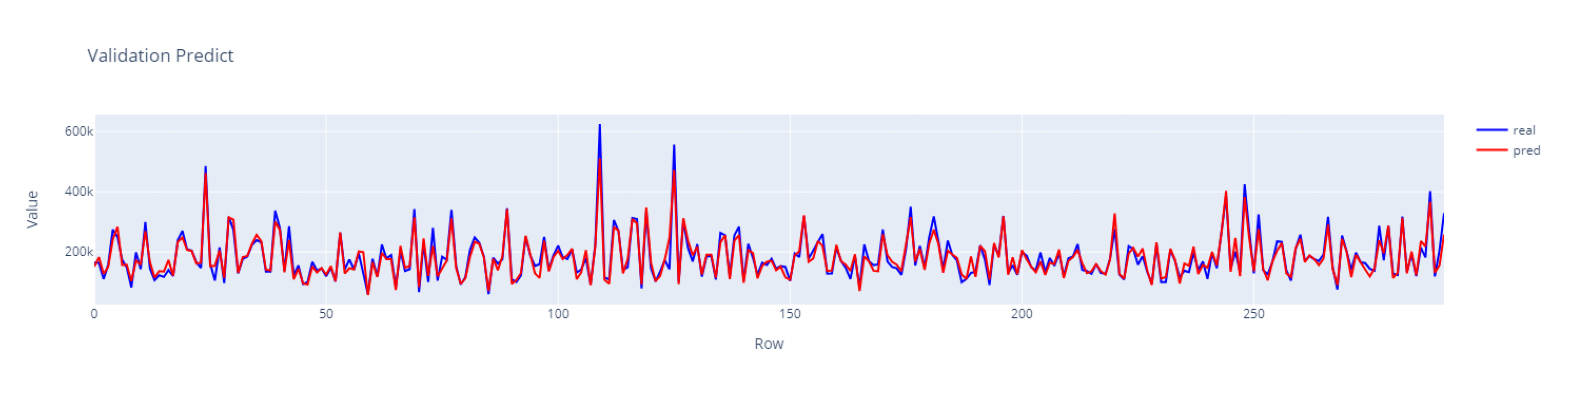

Fold No :  1
RMSE :  26055.800928004734 RMSLE :  0.01613715559313929 MAE :  14981.10297642979 R2 Score :  0.8943644570210839 Adj. R2 Score :  0.8885382652292992


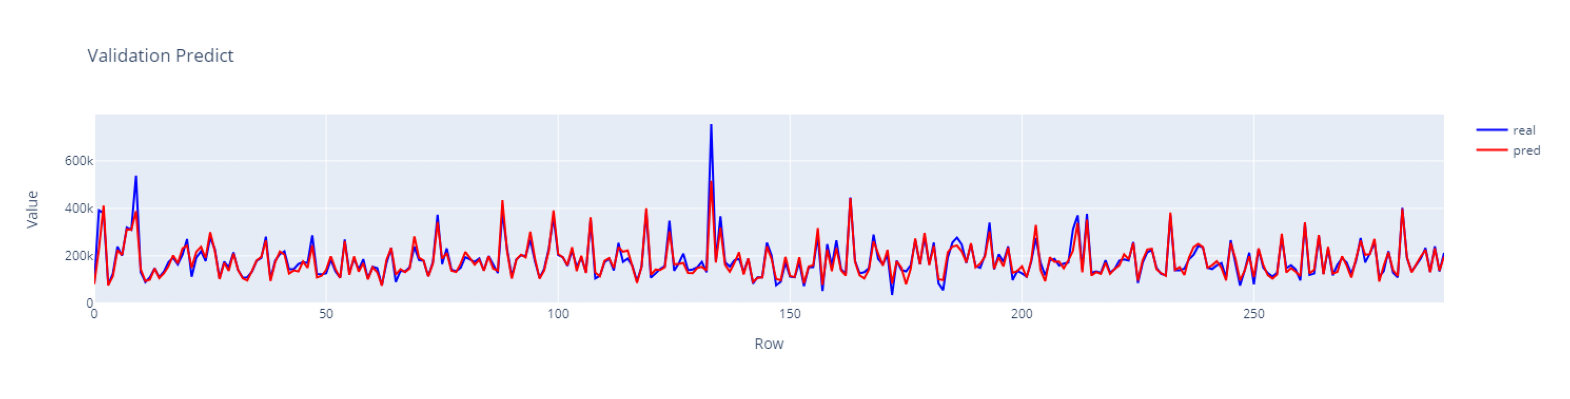

Fold No :  2
RMSE :  21123.96469842234 RMSLE :  0.013692433197432416 MAE :  14356.332894065315 R2 Score :  0.9225954055038463 Adj. R2 Score :  0.9183262551744925


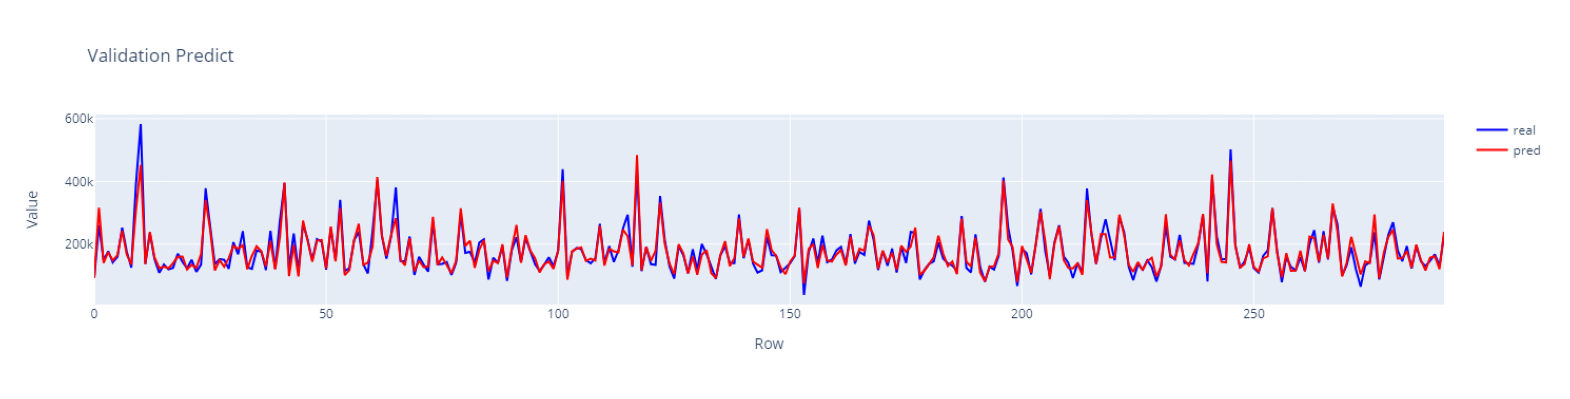

Fold No :  3
RMSE :  40742.014069538396 RMSLE :  0.05255678100219652 MAE :  23805.19948069503 R2 Score :  0.718363572614469 Adj. R2 Score :  0.7028302796031514


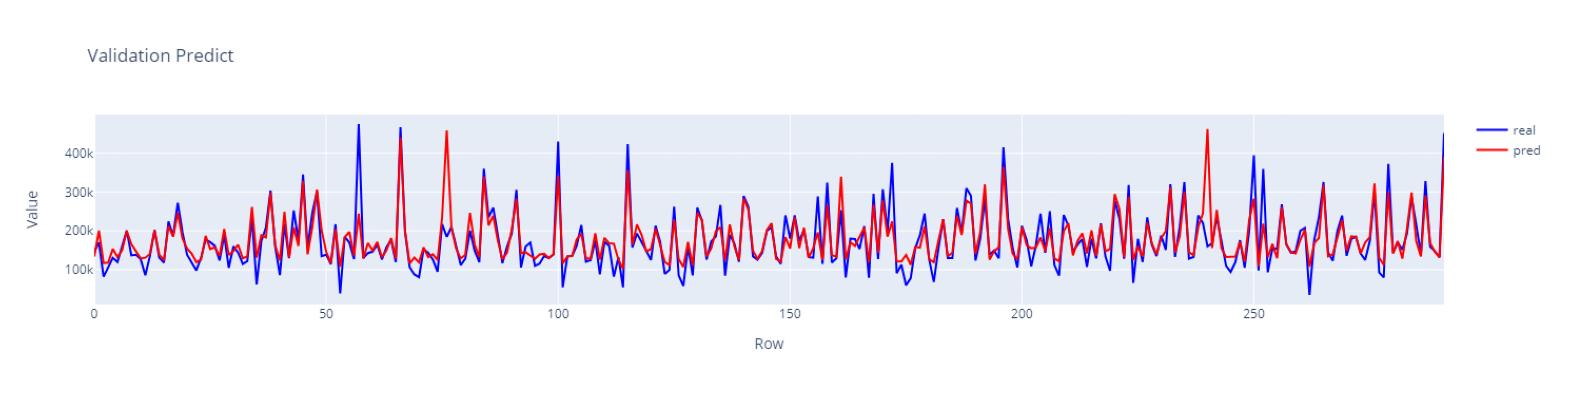

Fold No :  4
RMSE :  32537.33055105331 RMSLE :  0.020849523441995733 MAE :  18031.031749303722 R2 Score :  0.8595498437641662 Adj. R2 Score :  0.8518034969916655


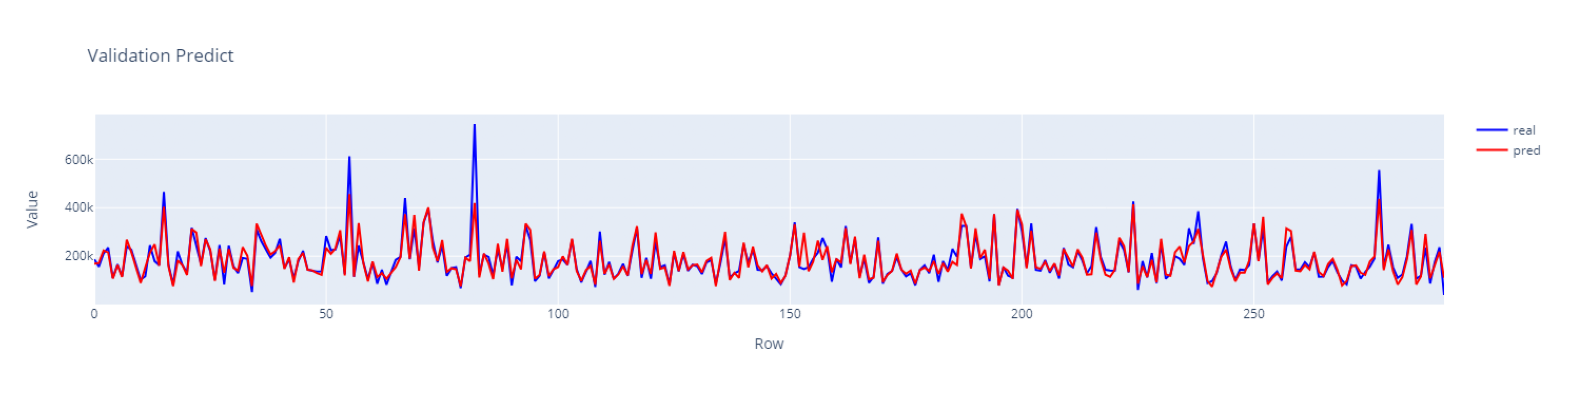

In [51]:
cv_results = []
for fold_no, (train_index, test_index) in enumerate(kf.split(X,y)):
    print("Fold No : ",fold_no)
    # Train ve validasyon setlerini alıyoruz.
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = cb.CatBoostRegressor(**best_params)
    model.fit(X_train, y_train,
                      eval_set=[(X_train,y_train),(X_test,y_test)],
                      early_stopping_rounds=200,verbose=0)
    y_pred = model.predict(X_test)
    external_test = external_test.reindex(X_test.columns, axis=1)
    external_pred = model.predict(external_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    rmsle = mean_squared_log_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)               
    adj_r2 = 1 - (1 - (r2_score(y_test, y_pred))) * (X_train.shape[0] - 1) / (X_train.shape[0] - len(X_train.columns.tolist()) - 1)
    print("RMSE : ", rmse,
         "RMSLE : ",rmsle,
         "MAE : ", mae,
         "R2 Score : ", r2,
         "Adj. R2 Score : ",adj_r2)
    pred=pd.DataFrame(y_pred,columns=['pred'])
    real_and_pred = pd.concat([y_test.reset_index(drop=True),pred],axis=1)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=real_and_pred.index, y=real_and_pred['SalePrice'], mode='lines', name='real', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=real_and_pred.index, y=real_and_pred['pred'], mode='lines', name='pred', line=dict(color='red')))
    fig.update_layout(title='Validation Predict', xaxis_title='Row', yaxis_title='Value')
    # GitHub only displays static images, so I saved the images and visualized them later.
    try:
        image = imread(f"C:/Users/MahmutYAVUZ/Desktop/Software/Python/kaggle/regression/images/train_{fold_no}.png")
        fig, ax = plt.subplots(figsize=(20, 25))  
        ax.imshow(image)
        ax.axis('off')  
        plt.show()
    except:
        fig.show()
    cv_results.append({'fold_no': fold_no,
                       'rmse': rmse,
                       'mae': mae,
                       'rmsle': rmsle,
                       'r2': r2,
                       'adj_r2': adj_r2,
                       'real': y_test.tolist(), 'pred': y_pred.tolist(),
                      'external_pred' : external_pred})

In [52]:
best_fold_no = min(cv_results, key=lambda x: x['rmse'])['fold_no']

In [53]:
submission = pd.DataFrame({'Id': test['Id'],
                       'SalePrice': cv_results[best_fold_no]['external_pred'].squeeze()})
submission.to_csv('submission.csv', index=False)
submission.head()

Id  SalePrice
0  1461  117628.39
1  1462  166096.43
2  1463  192648.77
3  1464  194972.84
4  1465  181138.28

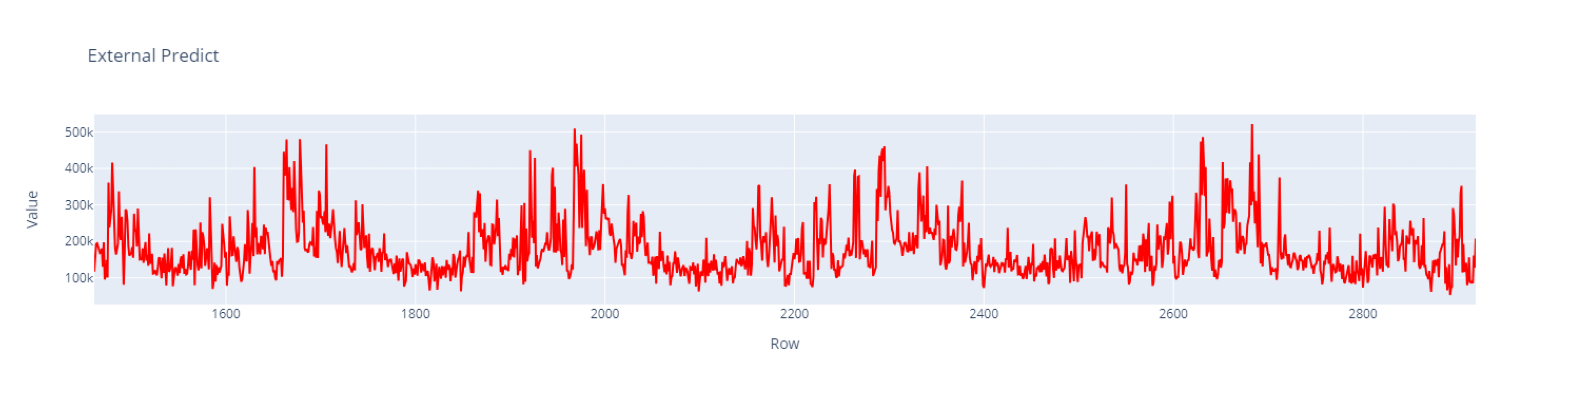

In [54]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=submission['Id'], y=submission['SalePrice'], mode='lines', name='pred', line=dict(color='red')))
fig.update_layout(title='External Predict', xaxis_title='Row', yaxis_title='Value')
# GitHub only displays static images, so I saved the images and visualized them later.
try:
    image = imread(f"C:/Users/MahmutYAVUZ/Desktop/Software/Python/kaggle/regression/images/external.png")
    fig, ax = plt.subplots(figsize=(20, 25))  
    ax.imshow(image)
    ax.axis('off')  
    plt.show()
except:
    fig.show()